In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
drive.mount('/content/drive')

Mounted at /content/drive


##**Load_Def**

In [2]:
def preprocess_data(data):
  p_data = pd.DataFrame();
  p_data['CLOSE'] = data['Close/Last'].apply(lambda x: x.replace("$",""))
  p_data['CLOSE'] = p_data['CLOSE'].apply(lambda x: float(x));
  p_data['OPEN'] = data['Open'].apply(lambda x: x.replace("$",""))
  p_data['OPEN'] = p_data['OPEN'].apply(lambda x: float(x));
  p_data['HIGH'] = data['High'].apply(lambda x: x.replace("$",""))
  p_data['HIGH'] = p_data['HIGH'].apply(lambda x: float(x));
  p_data['LOW'] = data['Low'].apply(lambda x: x.replace("$",""))
  p_data['LOW'] = p_data['LOW'].apply(lambda x: float(x));
  p_data['Volume'] = data['Volume'].apply(lambda x: float(x));
  p_data['Date'] = pd.to_datetime(data['Date'],format='%m/%d/%Y')
  #p_data.set_index('Date',inplace=True)

  return p_data;

In [3]:
def update_fx_data(data,rate):
    from datetime import datetime, timedelta
    import requests
    import pandas as pd

    # Drop unnecessary column if present
    if 'Unnamed: 0' in data.columns:
        data.drop(columns=['Unnamed: 0'], inplace=True)

    # Get the last unique date
    reference_date = data.DATE.unique()[-1]  # Timestamp object
    try:

      reference_date_str = reference_date.strftime('%Y-%m-%d %H:%M:%S')

    except:

      reference_date_str = reference_date
        # Convert to string

    # Extract hour and minute as integers
    last_minute = int(reference_date_str[14:16])  # Extract minute part
    last_hour = int(reference_date_str[11:13])  # Extract hour part

    # Parse date part
    date = datetime.strptime(reference_date_str[:10], '%Y-%m-%d')

    # Update the minute and hour logic
    if last_minute == 59:  # Handle the case where we roll over to the next hour
        last_minute = 0
        last_hour += 1
        if last_hour == 24:  # Handle the case where we roll over to the next day
            last_hour = 0
            date += timedelta(days=1)
    else:
        last_minute += 1

    # Format new date-time string
    new_date = f"{date.strftime('%Y-%m-%d')} {last_hour:02}:{last_minute:02}:00"

    # Fetch data from Tiingo API
    tiingo_key = '3246c1457e56416d59a5792c394b025c1bd62207'
    headers = {'Content-Type': 'application/json'}
    url = f"https://api.tiingo.com/tiingo/fx/xauusd/prices?startDate={new_date}&resampleFreq={rate}&token={tiingo_key}"

    request_response = requests.get(url, headers=headers)
    if request_response.status_code != 200:
        raise ValueError(f"Error fetching data: {request_response.text}")

    # Parse the response and create a DataFrame
    ds = pd.DataFrame(request_response.json())
    if ds.empty:
        print("No new data fetched.")
        return data, pd.DataFrame()  # Return the original data if no new data is fetched

    # Clean and prepare the fetched data
    ds.drop(columns=['ticker'], inplace=True)
    ds.rename(columns={'date': 'DATE', 'open': 'OPEN', 'high': 'HIGH', 'low': 'LOW', 'close': 'CLOSE'}, inplace=True)

    # Convert fetched DATE column to datetime (remove timezone)
    ds['DATE'] = pd.to_datetime(ds['DATE']).dt.tz_localize(None)  # Remove timezone awareness

    # Convert existing dataset's DATE column to datetime if not already
    if data['DATE'].dtype == 'object':
        data['DATE'] = pd.to_datetime(data['DATE'])

    # Concatenate new data with the existing data
    data = pd.concat([data, ds], ignore_index=True)
    data.drop_duplicates(subset=['DATE'], inplace=True)  # Remove duplicate entries
    data.sort_values(by='DATE', inplace=True)  # Sort data by DATE

    # Print the last date in the updated dataset
    print(f"Updated dataset. Latest date: {data.DATE.values[-1]}")

    # Return the updated dataset and the new data fetched
    return data, ds


In [4]:
from plotly.offline import iplot

def plot_fx_data(data, start_date, end_date, plot_type="candlestick", interval_minutes=1):
    data['DATE'] = pd.to_datetime(data['DATE'])
    filtered_data = data[(data['DATE'] >= start_date) & (data['DATE'] <= end_date)].copy()

    if filtered_data.empty:
        raise ValueError("No data available for the specified date range.")

    if plot_type == "candlestick":
        filtered_data.set_index('DATE', inplace=True)
        aggregated_data = filtered_data.resample(f'{interval_minutes}T').agg({
            'OPEN': 'first',
            'HIGH': 'max',
            'LOW': 'min',
            'CLOSE': 'last'
        }).dropna().reset_index()

        fig = go.Figure(data=[
            go.Candlestick(
                x=aggregated_data['DATE'],
                open=aggregated_data['OPEN'],
                high=aggregated_data['HIGH'],
                low=aggregated_data['LOW'],
                close=aggregated_data['CLOSE'],
                name="Candlesticks"
            )
        ])
        fig.update_layout(title=f"{interval_minutes}-Minute Candlestick Chart", xaxis_title="Date", yaxis_title="Price")
    elif plot_type == "curve":
        fig = go.Figure(data=[
            go.Scatter(
                x=filtered_data['DATE'],
                y=filtered_data['CLOSE'],
                mode='lines',
                name="Close Price"
            )
        ])
        fig.update_layout(title="Curve Plot", xaxis_title="Date", yaxis_title="Price")
    else:
        raise ValueError("Invalid plot_type. Choose either 'candlestick' or 'curve'.")

    fig.update_layout(
        xaxis_rangeslider_visible=(plot_type == "candlestick"),
        template="plotly_white",
        hovermode="x unified"
    )

    # Explicitly render the plot
    iplot(fig)

    # Return None to avoid implicit rendering
    return None


In [5]:
def process_xau_data(df):
    # Convert 'Date' to datetime, inferring format automatically
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, errors='coerce')

    # Convert columns 'Price', 'Open', 'High', 'Low' to numeric, removing commas
    numeric_columns = ['Price', 'Open', 'High', 'Low']
    for col in numeric_columns:
        df[col] = df[col].str.replace(',', '').astype(float)

    # Convert 'Change %' to numeric by removing '%' and dividing by 100
    df['Change %'] = df['Change %'].str.replace('%', '').astype(float) / 100

    return df

In [6]:
import os
import pandas as pd
from datetime import datetime

def build_historical_dataset(folder_path, output_file):
    """
    Builds the historical dataset by stacking all CSV files in the specified folder.

    Args:
        folder_path (str): Path to the folder containing yearly CSV files.
        output_file (str): Path to save the combined historical dataset.

    Returns:
        pd.DataFrame: Combined historical dataset.
    """
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    all_data = []

    for file in sorted(all_files):  # Ensure files are processed in chronological order
        file_path = os.path.join(folder_path, file)

        # Read the file and set column names
        data = pd.read_csv(
            file_path,
            sep=";",  # Specify the delimiter
            header=None,  # Indicate no headers
            names=['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']  # Set column names
        )

        # Standardize the date format
        data['DATE'] = pd.to_datetime(data['DATE'], format='%Y%m%d %H%M%S', errors='coerce')
        all_data.append(data)

    historical_data = pd.concat(all_data, ignore_index=True)
    historical_data.drop_duplicates(subset=['DATE'], inplace=True)
    historical_data.sort_values(by='DATE', inplace=True)

    # Save the combined dataset
    historical_data.to_csv(output_file, index=False)
    print(f"Historical dataset saved to {output_file}")

    return historical_data

In [7]:
import os
import pandas as pd
from datetime import datetime

def build_historical_MT_dataset(folder_path, output_file):
    """
    Builds the historical dataset by stacking all CSV files in the specified folder.

    Args:
        folder_path (str): Path to the folder containing yearly CSV files.
        output_file (str): Path to save the combined historical dataset.

    Returns:
        pd.DataFrame: Combined historical dataset.
    """
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    all_data = []

    for file in sorted(all_files):  # Ensure files are processed in chronological order
        file_path = os.path.join(folder_path, file)

        # Read the file and set column names
        data = pd.read_csv(file_path,
                   sep=",",  # Specify the delimiter
                   header=None)
        data.columns = ['DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']
        data['DATETIME'] = pd.to_datetime(data['DATE'] + ' ' + data['TIME'])
        data.drop(columns=['DATE','TIME'],inplace = True)
        data.rename(columns={'DATETIME': 'DATE'}, inplace=True)
        # Standardize the date format
        data['DATE'] = pd.to_datetime(data['DATE'], format='%Y%m%d %H%M%S', errors='coerce')
        all_data.append(data)

    historical_data = pd.concat(all_data, ignore_index=True)
    historical_data.drop_duplicates(subset=['DATE'], inplace=True)
    historical_data.sort_values(by='DATE', inplace=True)

    # Save the combined dataset
    historical_data.to_csv(output_file, index=False)
    print(f"Historical dataset saved to {output_file}")

    return historical_data

#**Build_HDS_kaggle**

In [ ]:
#historical_data_kaggle = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/database/goldusd_kaggle_data/XAU_5m_data_2004_to_2024-09-20.csv')

In [ ]:
#historical_data_kaggle['DATETIME'] = pd.to_datetime(historical_data_kaggle['Date'] + ' ' + historical_data_kaggle['Time'])
#historical_data_kaggle.drop(columns=['Date','Time'],inplace = True)
#historical_data_kaggle.rename(columns={'DATETIME': 'DATE', 'Open':'OPEN', 'High':'HIGH', 'Low':'LOW', 'Close':'CLOSE'}, inplace=True)
## Standardize the date format
#historical_data_kaggle['DATE'] = pd.to_datetime(historical_data_kaggle['DATE'], format='%Y%m%d %H%M%S', errors='coerce')

##*Update_HDS*

In [ ]:
# Assuming historical_data is your existing dataset
folder_path = "/content/drive/MyDrive/Colab Notebooks/HFFX_Project/database/goldusd_kaggle_data"
output_file = os.path.join(folder_path, "processed_historical_data/5m_historical_data.csv")
historical_data_kaggle = pd.read_csv(output_file)
historical_data_kaggle, new_data = update_fx_data(historical_data_kaggle,'5min')

Updated dataset. Latest date: 2024-12-16T23:45:00.000000000


In [ ]:
historical_data_kaggle.to_csv(output_file, index=False)

#**Build_HDS_MT**

In [8]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/archive_file_MT"
output_file = os.path.join(folder_path, "FULLTABLE/historical_xau_usd_data.csv")

# Build the historical dataset
#historical_data_MT = build_historical_MT_dataset(folder_path, output_file)

##*Update_HDS*

In [9]:
historical_data_MT = pd.read_csv(output_file)
historical_data_MT, new_data = update_fx_data(historical_data_MT,'1min')

Updated dataset. Latest date: 2025-01-07T23:15:00.000000000


In [10]:
historical_data_MT.to_csv(output_file, index=False)

#**Build_HDS_ASCII**

In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/archive_file"
output_file = os.path.join(folder_path, "FULLTABLE/historical_xau_usd_data.csv")

# Build the historical dataset
#historical_data_ASCII = build_historical_MT_dataset(folder_path, output_file)

##*Update_HDS*

In [ ]:
# Assuming historical_data is your existing dataset
historical_data_ASCII = pd.read_csv(output_file)
historical_data_ASCII, new_data = update_fx_data(historical_data_ASCII,'1min')

Updated dataset. Latest date: 2024-12-23T21:58:00.000000000


In [ ]:
historical_data_kaggle.iloc[0].to_dict()

NameError: name 'historical_data_kaggle' is not defined

In [ ]:
historical_data_kaggle.iloc[-1].to_dict()

In [ ]:
historical_data_ASCII.to_csv(output_file, index=False)

#*GraphPlotty*

In [ ]:
# Plot candlesticks with 5-minute intervals
historical_data_MT, new_data = update_fx_data(historical_data_MT,'1min')

Updated dataset. Latest date: 2025-01-06T16:47:00.000000000


In [12]:
# Define the date range and call the function
import plotly.graph_objects as go
start_date = "2025-01-07 12:00:00"
end_date = "2025-01-08 23:59:00"
plot_fx_data(historical_data_MT, start_date, end_date, plot_type="candlestick", interval_minutes=5)

<ipython-input-4-d7c837ac13dc>:12: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [ ]:
#processed_df = processed_df.sort_values(by='Date')
#processed_df.drop(columns=['Vol.'],inplace = True)
#processed_df.rename(columns={'Date': 'Time'}, inplace=True)

In [ ]:
#btc_df = btc_df.sort_values(by='Date')
#btc_df.drop(columns=['Vol.'],inplace = True)
#btc_df.rename(columns={'Date': 'Time'}, inplace=True)

#*Intraday_ML*

In [ ]:
len(historical_data_MT)

5507606

In [ ]:
historical_data_MT.iloc[-1].to_dict()

{'OPEN': 2645.87,
 'HIGH': 2646.35,
 'LOW': 2645.77,
 'CLOSE': 2646.35,
 'VOLUME': nan,
 'DATE': Timestamp('2024-12-17 21:58:00')}

In [39]:
start_date = "2009-03-15 17:00:00"
end_date = "2025-01-08 00:00:00"

In [40]:
historical_data_MT['DATE'] = pd.to_datetime(historical_data_MT['DATE'])
filtered_data = historical_data_MT[(historical_data_MT['DATE'] >= start_date) & (historical_data_MT['DATE'] <= end_date)].copy()
filtered_data.set_index('DATE', inplace=True)
aggregated_data = filtered_data.resample(f'{720}T').agg({
    'OPEN': 'first',
    'HIGH': 'max',
    'LOW': 'min',
    'CLOSE': 'last'
}).dropna().reset_index()

<ipython-input-40-db8e8b83c2b8>:4: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [41]:
aggregated_data.iloc[-1].to_dict()

{'DATE': Timestamp('2025-01-07 12:00:00'),
 'OPEN': 2648.51,
 'HIGH': 2664.35,
 'LOW': 2643.15,
 'CLOSE': 2649.35}

In [ ]:
len(aggregated_data)

223

In [19]:
# Assuming btc_df is already preprocessed (e.g., btc_df.dropna())
df = aggregated_data
# 1. Calculate differential features (daily returns)
df['Price_return'] = df['CLOSE'].diff()
df['Open_return'] = df['OPEN'].diff()
df['High_return'] = df['HIGH'].diff()
df['Low_return'] = df['LOW'].diff()

# 2. Adding Moving Averages (SMA and EMA)
df['SMA_10'] = df['CLOSE'].rolling(window=10).mean()  # 10-day Simple Moving Average
df['SMA_30'] = df['CLOSE'].rolling(window=30).mean()  # 30-day Simple Moving Average
df['EMA_10'] = df['CLOSE'].ewm(span=10, adjust=False).mean()  # 10-day Exponential Moving Average
df['EMA_30'] = df['CLOSE'].ewm(span=30, adjust=False).mean()  # 30-day Exponential Moving Average

# 3. Adding Volatility (Rolling Standard Deviation)
df['Volatility_10'] = df['CLOSE'].rolling(window=10).std()  # 10-day rolling volatility
df['Volatility_30'] = df['CLOSE'].rolling(window=30).std()  # 30-day rolling volatility

# 4. Adding daily_return (Price - Open)
df['daily_return'] = df['CLOSE'] - df['OPEN']

# Drop NaNs introduced by diff()
df = df.dropna().reset_index(drop=True)

def prepare_sequences(df, input_features, target_features, n_steps, m_steps):
    X, y = [], []
    for i in range(len(df) - n_steps - m_steps + 1):
        # X: n points up to `i + n_steps`
        X.append(df[input_features].iloc[i:i + n_steps].values)
        # y: m points starting immediately after `X`
        y.append(df[target_features].iloc[i + n_steps:i + n_steps + m_steps].values)
    return np.array(X), np.array(y)


# Configuration
input_features = ['Open_return','High_return','Low_return','LOW','HIGH','Price_return','CLOSE', 'SMA_10', 'SMA_30', 'Volatility_10', 'Volatility_30']
target_features = ['High_return','Low_return','Open_return','Price_return']
n_steps = 64
m_steps = 1

# Prepare sequences
X, y = prepare_sequences(df, input_features, target_features, n_steps, m_steps)

class IdentityScaler:
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X
    def fit_transform(self, X, y=None):
        return self.transform(X)
    def inverse_transform(self, X):
        return X
# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X.reshape(-1, len(input_features))).reshape(X.shape)
y = scaler_y.fit_transform(y.reshape(-1, len(target_features))).reshape(y.shape)

# Train-test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

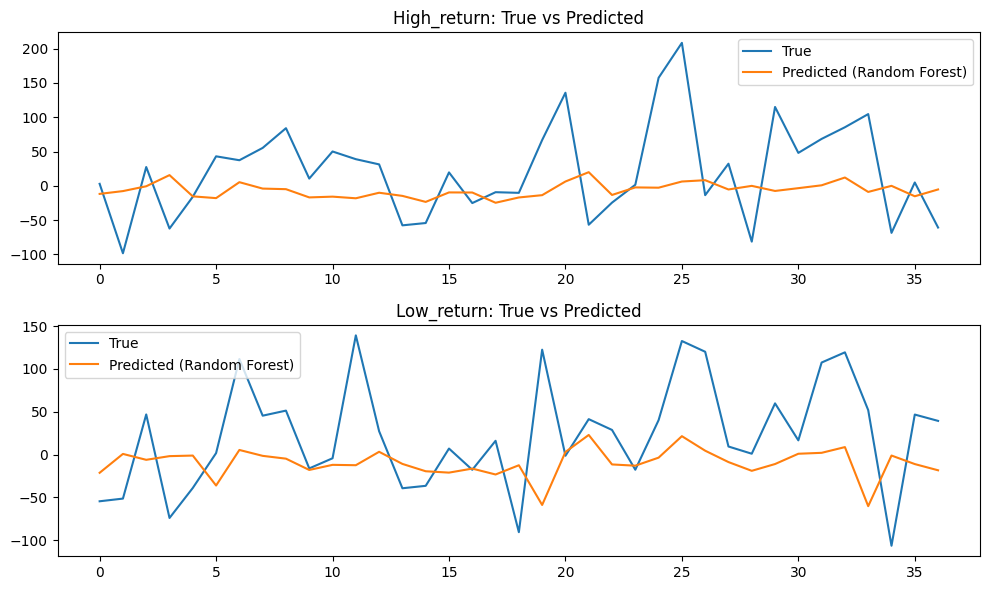

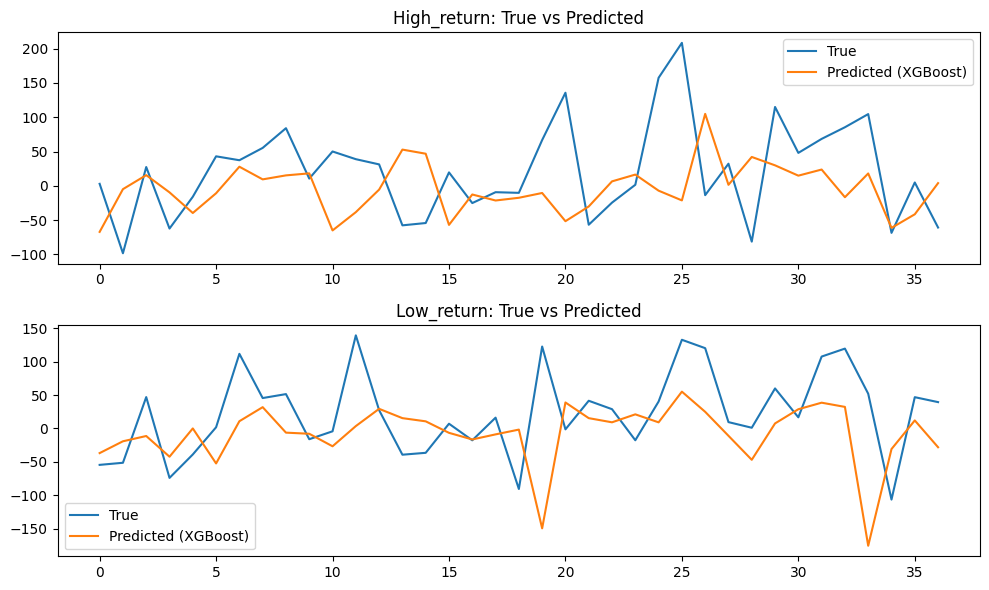

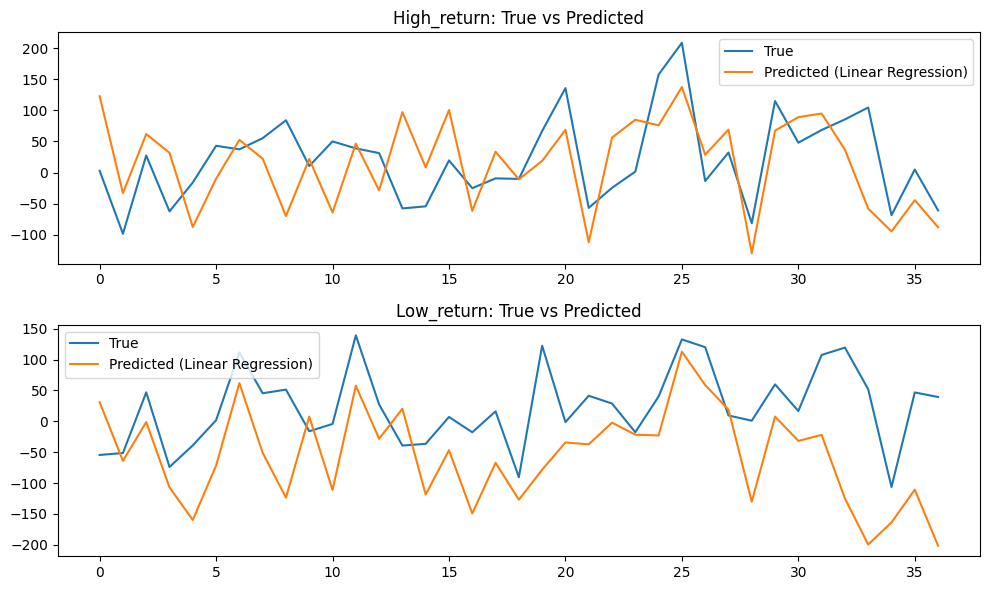

Random Forest:
  MSE: 5210.250522783317
  MAE: 57.1641018918919
  R2: -0.22018966848643717

XGBoost:
  MSE: 6707.750818611432
  MAE: 61.62887251400062
  R2: -0.5661238529938416

Linear Regression:
  MSE: 8554.78304080545
  MAE: 74.0609628184083
  R2: -1.0804293286067175



AssertionError: Expected 8 features, but got 96.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Models to train
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}

# Flatten X_train and X_test from 3D to 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Reshape y_train and y_test to 2D (if m_steps > 1, this will ensure correct shape)
y_train_2d = y_train.reshape(y_train.shape[0], -1)
y_test_2d = y_test.reshape(y_test.shape[0], -1)

# Train and evaluate models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_2d, y_train_2d)

    # Predictions
    y_pred = model.predict(X_test_2d)

    # Reshape predictions and inverse transform
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test_2d)

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred)
    mae = mean_absolute_error(y_test_inv, y_pred)
    r2 = r2_score(y_test_inv, y_pred)

    results[model_name] = {"MSE": mse, "MAE": mae, "R2": r2}

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(len(target_features)):
        plt.subplot(len(target_features), 1, i + 1)
        plt.plot(y_test_inv[:, i], label="True")
        plt.plot(y_pred[:, i], label=f"Predicted ({model_name})")
        plt.title(f"{target_features[i]}: True vs Predicted")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Display results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value}")
    print()

# Predict future points using the latest window
def predict_future(model, last_window, n_future, scaler_X, scaler_y):
    """
    Predicts `n_future` steps into the future using the given model and the last available window.
    """
    predictions = []
    current_window = last_window.reshape(1, -1)  # Ensure it's 2D and matches scaler dimensions

    for _ in range(n_future):
        # Check dimensions
        assert current_window.shape[1] == scaler_X.n_features_in_, \
            f"Expected {scaler_X.n_features_in_} features, but got {current_window.shape[1]}."

        # Transform the current window using the scaler
        current_window_scaled = scaler_X.transform(current_window)

        # Predict the next step
        next_pred = model.predict(current_window_scaled.reshape(1, -1))

        # Inverse transform the prediction
        next_pred = scaler_y.inverse_transform(next_pred.reshape(1, -1))

        # Append the prediction
        predictions.append(next_pred.flatten())

        # Update the current window with the latest prediction
        next_input = np.hstack([current_window[:, len(target_features):], next_pred])
        current_window = next_input.reshape(1, -1)

    return np.array(predictions)

# Predict future points
n_future = 5
last_window = X[-1].reshape(1, -1)  # Reshape the last available window correctly
future_predictions = predict_future(models["Random Forest"], last_window, n_future, scaler_X, scaler_y)

# Print predictions
print(f"Future predictions (next {n_future} steps):\n{future_predictions}")

# Plot future predictions
plt.figure(figsize=(10, 6))
for i, feature in enumerate(target_features):
    plt.plot(range(n_future), future_predictions[:, i], label=f"Predicted {feature}")
plt.title("Future Predictions")
plt.xlabel("Future Steps")
plt.ylabel("Value")
plt.legend()
plt.show()


#**ML_Hourly_Models**


In [ ]:
# Reshape X_train, X_test, y_train, y_test for RandomForest and XGB
n_samples, n_timesteps, n_features = X_train.shape
X_train_flat = X_train.reshape(n_samples, n_timesteps * n_features)
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# If y_train is multi-output, ensure it's 2D
if len(y_train.shape) == 3:
    y_train_flat = y_train.reshape(y_train.shape[0], y_train.shape[1] * y_train.shape[2])
    y_test_flat = y_test.reshape(y_test.shape[0], y_test.shape[1] * y_test.shape[2])
else:
    y_train_flat = y_train
    y_test_flat = y_test

# Hyperparameter tuning for Random Forest
rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_flat, y_train_flat)

# Hyperparameter tuning for XGBoost
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_flat, y_train_flat)

# Evaluate models
def evaluate_model(model, X, y, scaler_y):
    y_pred = scaler_y.inverse_transform(model.predict(X).reshape(-1, y.shape[1]))
    y_true = scaler_y.inverse_transform(y)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2, y_true, y_pred

rf_best = rf_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

rf_mse, rf_mae, rf_r2, rf_y_true, rf_y_pred = evaluate_model(rf_best, X_test_flat, y_test, scaler_y)
xgb_mse, xgb_mae, xgb_r2, xgb_y_true, xgb_y_pred = evaluate_model(xgb_best, X_test_flat, y_test, scaler_y)

# Select the best model
if rf_mse < xgb_mse:
    best_model = rf_best
    best_model_name = "Random Forest"
else:
    best_model = xgb_best
    best_model_name = "XGBoost"

print(f"Best Model: {best_model_name}")
print(f"MSE: {min(rf_mse, xgb_mse):.4f}, MAE: {min(rf_mae, xgb_mae):.4f}, R2: {max(rf_r2, xgb_r2):.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning:

The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.



AttributeError: 'super' object has no attribute '__sklearn_tags__'

#**CNNDNN Modeling**


In [20]:
from tensorflow.keras import layers

class ReshapeLayer(layers.Layer):
    def __init__(self, axis=1):
        super(ReshapeLayer, self).__init__()
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

In [21]:
class ReshapeOLayer(layers.Layer):
    def __init__(self, shape):
        super(ReshapeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs):
        return tf.reshape(inputs, self.shape)

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam



from tensorflow.keras.layers import Conv1D, LeakyReLU, LSTM, Bidirectional, Dropout, Dense, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def build_proposed_cnn_bilstm(input_shape, output_size, m_steps):
    model = Sequential([
        Conv1D(filters=32, kernel_size=1, kernel_regularizer=l2(0.001), input_shape=input_shape),
        LeakyReLU(alpha=0.01),  # Replace ReLU with Leaky ReLU
        Bidirectional(LSTM(20, return_sequences=True, kernel_regularizer=l2(0.001))),
        Dropout(0.2),  # Increase dropout
        Bidirectional(LSTM(20, return_sequences=False, kernel_regularizer=l2(0.001))),
        Dropout(0.2),
        Dense(m_steps * output_size, kernel_regularizer=l2(0.001)),
        Reshape((m_steps, output_size))
    ])
    return model



input_shape = (n_steps, len(input_features))
output_size = len(target_features)
model = build_proposed_cnn_bilstm(input_shape, output_size, m_steps)

# Compile model
optimizer = Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
# ValidationMetrics Callback
class ValidationMetrics(Callback):
    def __init__(self, validation_data, scaler_y):
        super().__init__()
        self.validation_data = validation_data
        self.scaler_y = scaler_y

    def on_epoch_end(self, epoch, logs=None):
        try:
            X_val, y_val = self.validation_data
            y_pred_val = self.model.predict(X_val)

            # Reshape predictions and true values for scaling back
            y_pred_val = y_pred_val.reshape(-1, y_pred_val.shape[-1])
            y_true_val = y_val.reshape(-1, y_val.shape[-1])

            y_pred_val = self.scaler_y.inverse_transform(y_pred_val)
            y_true_val = self.scaler_y.inverse_transform(y_true_val)

            # Compute metrics
            val_r2 = r2_score(y_true_val, y_pred_val)
            val_mae = mean_absolute_error(y_true_val, y_pred_val)
            print(f"Epoch {epoch+1} - Validation R²: {val_r2:.4f}, Validation MAE: {val_mae:.4f}")
        except Exception as e:
            print(f"Epoch {epoch+1} - Error in validation metrics: {e}")

# Callbacks
early_stopping = EarlyStopping(monitor='val_mae', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6)
metrics_callback = ValidationMetrics(validation_data=(X_test, y_test), scaler_y=scaler_y)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=30,  # As per the table
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, metrics_callback],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Epoch 1 - Validation R²: 0.1010, Validation MAE: 8.0791
238/238 ━━━━━━━━━━━━━━━━━━━━ 50s 124ms/step - loss: 0.7766 - mae: 0.6156 - val_loss: 0.8695 - val_mae: 0.8038 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Epoch 2 - Validation R²: 0.3690, Validation MAE: 6.2024
238/238 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - loss: 0.5558 - mae: 0.4945 - val_loss: 0.6649 - val_mae: 0.6171 - learning_rate: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Epoch 3 - Validation R²: 0.3836, Validation MAE: 5.9872
238/238 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - loss: 0.4819 - mae: 0.4370 - val_loss: 0.6336 - val_mae: 0.5957 - learning_rate: 0.0010
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Epoch 4 - Validation R²: 0.3881, Validation MAE: 6.1194
238/238 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - loss: 0.4646 - mae: 0.4282 - val_loss: 0.6413 - val_mae: 0.6088 - learning_rate: 0.0010
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/archive_file_MT/convlstm_network_100_1.keras')

In [ ]:
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable()
def rmse_sequence(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)
print(keras.__version__)
#regressor = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/database/XAu_USD/RNN_MODEL_30_RT.keras')
model = load_model(
    '/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/archive_file_MT/convlstm_network_100_1.keras'
)

2.17.1
3.5.0


In [23]:
def predict_future(df, n_steps, m_steps, input_features, target_features, forecast_days, scaler_X, scaler_y, model):
    """
    Predicts future values using the trained model, accommodating n_steps inputs and m_steps outputs.

    Args:
        df (pd.DataFrame): Dataframe containing the input features.
        n_steps (int): Number of timesteps for input sequences.
        m_steps (int): Number of timesteps for prediction output.
        input_features (list): List of input feature columns.
        target_features (list): List of target feature columns.
        forecast_days (int): Total number of timesteps to predict.
        scaler_X: Scaler used to scale input features.
        scaler_y: Scaler used to scale target features.
        model: Trained Keras model.

    Returns:
        np.array: Predicted future values (scaled back to original range).
    """
    # Extract the last n_steps of input data
    future_data = df[input_features].iloc[-n_steps:].values
    future_data = scaler_X.transform(future_data)  # Scale input features
    future_predictions = []

    for _ in range(forecast_days // m_steps):
        # Reshape the input data for prediction
        future_data_reshaped = future_data.reshape(1, n_steps, len(input_features))

        # Predict the next m_steps
        prediction = model.predict(future_data_reshaped, verbose=0)  # Shape: (1, m_steps, len(target_features))

        # Scale back the predictions to the original range
        prediction = scaler_y.inverse_transform(prediction[0])  # Shape: (m_steps, len(target_features))
        future_predictions.append(prediction)

        # Update the future_data for the next prediction
        # Use only the required number of target features and match the input feature dimensions
        new_data = np.zeros((m_steps, len(input_features)))  # Initialize with the correct input feature size
        for i, feature in enumerate(target_features):
            if feature in input_features:
                new_data[:, input_features.index(feature)] = prediction[:, target_features.index(feature)]

        future_data = np.concatenate((future_data[m_steps:], new_data), axis=0)

    return np.concatenate(future_predictions, axis=0)

In [24]:
# Define your features
input_features = ['Open_return','High_return','Low_return','LOW','HIGH','Price_return','CLOSE', 'SMA_10', 'SMA_30', 'Volatility_10', 'Volatility_30']
target_features = ['High_return','Low_return','Open_return','Price_return']
forecast_days = 10

# Assuming scalers and model are already defined
future_predictions = predict_future(
    df=aggregated_data,
    n_steps=n_steps,
    m_steps=m_steps,
    input_features=input_features,
    target_features=target_features,
    forecast_days=forecast_days,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    model=model
)

In [25]:
print("Future predictions shape:", future_predictions.shape)


# Assuming your model is predicting 10 features, but scaler_y was fitted on 2
y_pred_test = model.predict(X_test)

# Reshape the predictions and test data to 2D
y_pred_test_reshaped = y_pred_test.reshape(-1, y_pred_test.shape[-1])
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Apply inverse transformation
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test_reshaped)
y_test_inverse = scaler_y.inverse_transform(y_test_reshaped)

# Check reshaped shapes
print(f"Shape of y_pred_test_inverse: {y_pred_test_inverse.shape}")
print(f"Shape of y_test_inverse: {y_test_inverse.shape}")

# Evaluate the model
r2 = r2_score(y_test_inverse, y_pred_test_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_test_inverse)

print(f"Test R²: {r2:.4f}, Test MAE: {mae:.4f}")
print(future_predictions)

Future predictions shape: (10, 4)
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Shape of y_pred_test_inverse: (1781, 4)
Shape of y_test_inverse: (1781, 4)
Test R²: 0.4305, Test MAE: 5.6575
[[ -3.365514     2.788692    -0.91744494   0.21170956]
 [  6.8528895   -2.8498797    4.1329074    0.20747878]
 [-26.585295     6.1817274  -22.775755     0.7372052 ]
 [ 12.606688    11.810845    25.286692     0.9196439 ]
 [-14.922179    -9.944484   -26.179947     0.24119183]
 [  9.441958    26.821888    36.47201      1.1241541 ]
 [-21.33827    -10.6695     -33.455936     0.31025365]
 [ 11.35885      8.486888    20.556665     0.6841025 ]
 [-22.889156    -4.225844   -28.826622     0.53299373]
 [ 12.25768     10.611231    23.741781     0.8423482 ]]


In [26]:
aggregated_data.iloc[-1].to_dict()

{'DATE': Timestamp('2025-01-07 12:00:00'),
 'OPEN': 2648.51,
 'HIGH': 2664.35,
 'LOW': 2643.15,
 'CLOSE': 2649.35,
 'Price_return': 0.819999999999709,
 'Open_return': 13.740000000000236,
 'High_return': 15.579999999999927,
 'Low_return': 10.110000000000127,
 'SMA_10': 2644.125,
 'SMA_30': 2625.6073333333334,
 'EMA_10': 2641.5757631985757,
 'EMA_30': 2636.3198249714333,
 'Volatility_10': 10.395671374483374,
 'Volatility_30': 17.159605922157862,
 'daily_return': 0.8399999999996908}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_with_separate_confusion_matrices(
    model, X_test, y_test, scaler_y, target_labels, threshold=0.5
):
    """
    Evaluate the model and plot confusion matrices for each target separately.

    Args:
        model: Trained model to evaluate.
        X_test: Test input data.
        y_test: Test target data (scaled).
        scaler_y: Scaler used for the target data (for inverse transformation).
        target_labels: List of labels (e.g., ['Downtrend', 'Uptrend']).
        threshold: Decision threshold for binary classification.
    """
    # Predict using the model
    y_pred = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))
    y_test = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))

    # Binarize predictions and test data based on returns > 0
    y_pred_binary = (y_pred > 0).astype(int)
    y_test_binary = (y_test > 0).astype(int)

    # Evaluate for each target feature (column)
    for i, feature in enumerate(['High_return', 'Low_return', 'Open_return', 'Price_return']):
        print(f"\nConfusion Matrix for {feature}:")

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_binary[:, i], y_pred_binary[:, i])
        print(f"Confusion Matrix:\n{cm}")

        # Check if confusion matrix is valid for unpacking
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"True Negatives (TN): {tn}")
            print(f"False Positives (FP): {fp}")
            print(f"False Negatives (FN): {fn}")
            print(f"True Positives (TP): {tp}")
        else:
            print("Confusion matrix is not 2x2. Unpacking skipped.")

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
        plt.title(f'Confusion Matrix for {feature}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Generate classification report
        report = classification_report(
            y_test_binary[:, i], y_pred_binary[:, i], target_names=target_labels, zero_division=0
        )
        print(report)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Confusion Matrix for High_return:
Confusion Matrix:
[[599 303]
 [198 680]]
True Negatives (TN): 599
False Positives (FP): 303
False Negatives (FN): 198
True Positives (TP): 680


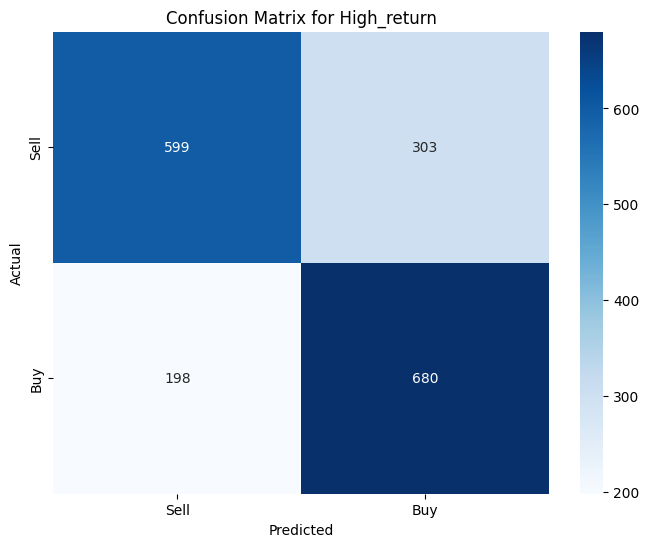

              precision    recall  f1-score   support

        Sell       0.75      0.66      0.71       902
         Buy       0.69      0.77      0.73       878

    accuracy                           0.72      1780
   macro avg       0.72      0.72      0.72      1780
weighted avg       0.72      0.72      0.72      1780


Confusion Matrix for Low_return:
Confusion Matrix:
[[588 236]
 [276 680]]
True Negatives (TN): 588
False Positives (FP): 236
False Negatives (FN): 276
True Positives (TP): 680


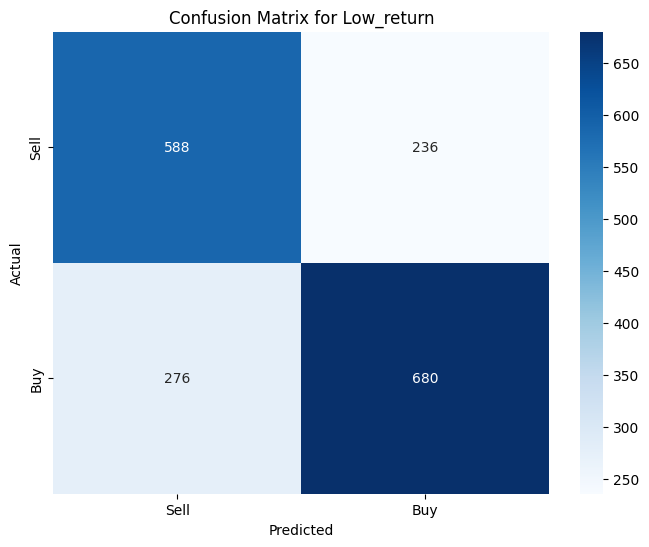

              precision    recall  f1-score   support

        Sell       0.68      0.71      0.70       824
         Buy       0.74      0.71      0.73       956

    accuracy                           0.71      1780
   macro avg       0.71      0.71      0.71      1780
weighted avg       0.71      0.71      0.71      1780


Confusion Matrix for Open_return:
Confusion Matrix:
[[808  35]
 [ 43 894]]
True Negatives (TN): 808
False Positives (FP): 35
False Negatives (FN): 43
True Positives (TP): 894


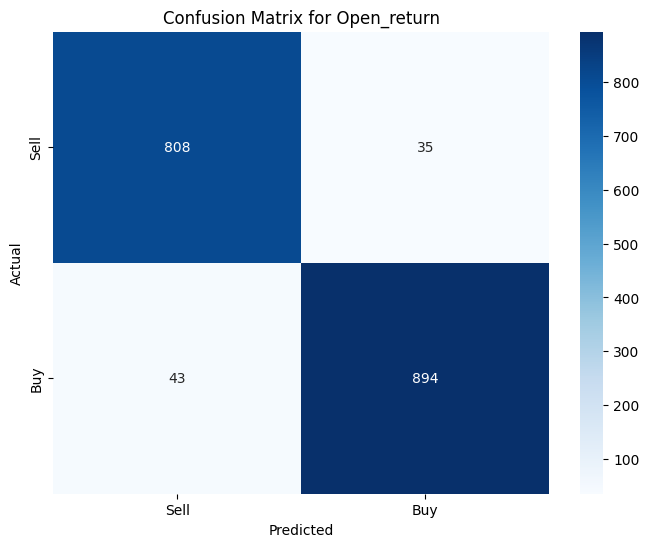

              precision    recall  f1-score   support

        Sell       0.95      0.96      0.95       843
         Buy       0.96      0.95      0.96       937

    accuracy                           0.96      1780
   macro avg       0.96      0.96      0.96      1780
weighted avg       0.96      0.96      0.96      1780


Confusion Matrix for Price_return:
Confusion Matrix:
[[  9 840]
 [  3 928]]
True Negatives (TN): 9
False Positives (FP): 840
False Negatives (FN): 3
True Positives (TP): 928


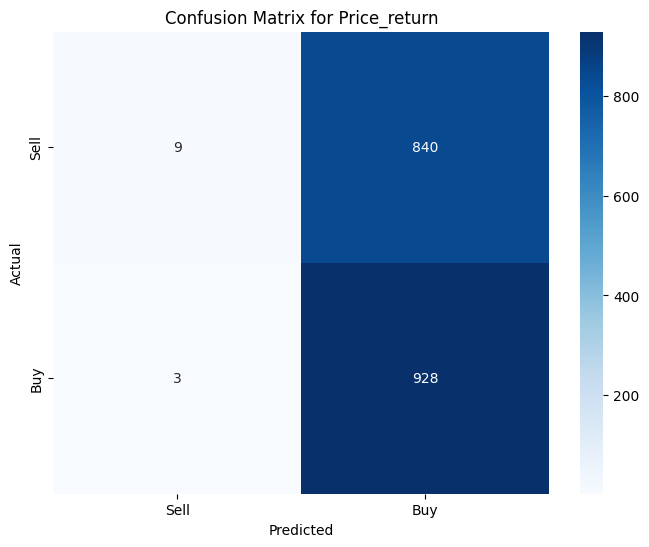

              precision    recall  f1-score   support

        Sell       0.75      0.01      0.02       849
         Buy       0.52      1.00      0.69       931

    accuracy                           0.53      1780
   macro avg       0.64      0.50      0.35      1780
weighted avg       0.63      0.53      0.37      1780



In [ ]:
evaluate_model_with_separate_confusion_matrices(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler_y=scaler_y,
    target_labels=['Sell', 'Buy']
)

In [ ]:
y_pred_test = model.predict(X_test)
import plotly.graph_objects as go
import plotly.io as pio
# High_return Plot
fig_high = go.Figure()

# Add actual High_return trace
fig_high.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test_inverse[:, 0],
    mode='lines',
    name='Actual High_return',
    line=dict(color='blue')
))

# Add predicted High_return trace
fig_high.add_trace(go.Scatter(
    x=list(range(len(y_pred_test))),
    y=y_pred_test_inverse[:, 0],
    mode='lines',
    name='Predicted High_return',
    line=dict(color='red', dash='dash')
))

# Customize layout for High_return
fig_high.update_layout(
    title='Actual vs. Predicted High_return',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='High Return (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show High_return plot
fig_high.show()

# Low_return Plot
fig_low = go.Figure()

# Add actual Low_return trace
fig_low.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test_inverse[:, 1],
    mode='lines',
    name='Actual Low_return',
    line=dict(color='blue')
))

# Add predicted Low_return trace
fig_low.add_trace(go.Scatter(
    x=list(range(len(y_pred_test))),
    y=y_pred_test_inverse[:, 1],
    mode='lines',
    name='Predicted Low_return',
    line=dict(color='red', dash='dash')
))

# Customize layout for Low_return
fig_low.update_layout(
    title='Actual vs. Predicted Low_return',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Low Return (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show Low_return plot
fig_low.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


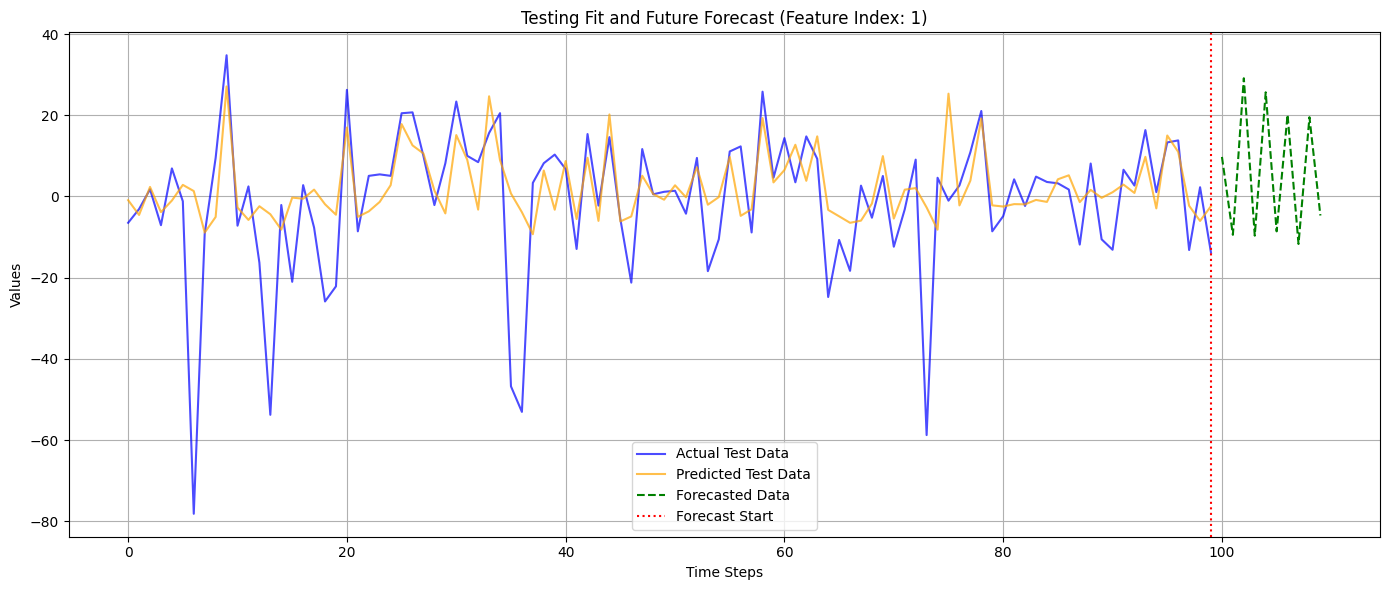

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_with_forecast(y_test_inverse, y_pred_test_inverse, future_predictions, feature_idx=0):
    """
    Plot testing fit and forecasted future points.

    Args:
        y_test_inverse (np.array): Inverse transformed actual test data.
        y_pred_test_inverse (np.array): Inverse transformed predicted test data.
        future_predictions (np.array): Forecasted future values.
        feature_idx (int): Index of the feature to plot.
    """
    # Create x-axis values
    x_test = np.arange(len(y_test_inverse[-100:]))
    x_forecast = np.arange(len(y_test_inverse[-100:]), len(y_test_inverse[-100:]) + len(future_predictions))

    plt.figure(figsize=(14, 6))

    # Plot the testing actual and predicted values
    plt.plot(x_test[-100:], y_test_inverse[-100:, feature_idx], label='Actual Test Data', color='blue', alpha=0.7)
    plt.plot(x_test[-100:], y_pred_test_inverse[-100:, feature_idx], label='Predicted Test Data', color='orange', alpha=0.7)

    # Plot the forecasted future values
    plt.plot(x_forecast, future_predictions[:, feature_idx], label='Forecasted Data', color='green', linestyle='--')

    plt.axvline(x=len(y_test_inverse[-100:]) - 1, color='red', linestyle=':', label='Forecast Start')

    # Add labels and legend
    plt.title(f"Testing Fit and Future Forecast (Feature Index: {feature_idx})")
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage for the first feature in the target features
plot_predictions_with_forecast(y_test_inverse, y_pred_test_inverse, future_predictions, feature_idx=1)


##**Calculate_confidence**


In [27]:
import numpy as np
import pandas as pd

def find_misclassifications(X_test, y_test, y_pred, target_index, threshold=0.0):
    """
    Identifies misclassified inputs where predictions failed to match actual return direction.

    Args:
        X_test (np.array): Input features (original scale or transformed).
        y_test (np.array): Actual target values.
        y_pred (np.array): Predicted target values.
        target_index (int): Index of the target feature to analyze (e.g., 'High_return' or 'Low_return').
        threshold (float): Decision boundary for positive/negative classification.

    Returns:
        misclassified_df (pd.DataFrame): Dataframe of misclassified inputs with actual/predicted labels.
    """
    # Extract the relevant target column
    y_actual = y_test[:, target_index]
    y_predicted = y_pred[:, target_index]

    # Define the sign-based classification
    actual_sign = np.where(y_actual > threshold, 1, -1)  # 1 = positive return, -1 = negative return
    predicted_sign = np.where(y_predicted > threshold, 1, -1)

    # Find misclassified indices
    misclassified_indices = np.where(actual_sign != predicted_sign)[0]
    right_indices = np.where(actual_sign == predicted_sign)[0]

    # Create a dataframe of misclassified inputs and results
    # Ensure all arrays are 1D
    misclassified_data = {
        'Actual_Return': y_actual[misclassified_indices].ravel(),
        'Predicted_Return': y_predicted[misclassified_indices].ravel(),
        'Actual_Sign': actual_sign[misclassified_indices].ravel(),
        'Predicted_Sign': predicted_sign[misclassified_indices].ravel(),
    }

    # Add input features, ensuring they're 1D
    for i in range(X_test.shape[1]):
        misclassified_data[f'Feature_{i+1}'] = X_test[misclassified_indices, i].ravel()

    return misclassified_data, misclassified_indices, right_indices


In [34]:
misclassified_data, wrong_indices, right_indices = find_misclassifications(
    X_test=X_test,
    y_test=y_test_inverse,
    y_pred=y_pred_test_inverse,
    target_index=0,
    threshold=0.0
)

print("Misclassified Instances:")


Misclassified Instances:


In [ ]:
X_test.shape

(950, 120, 11)

In [35]:
import numpy as np
import pandas as pd


# Function to calculate features for each set (window)
def calculate_features(window):
    features = {}

    # Statistical features for each feature dimension
    for dim in range(window.shape[1]):
        dim_data = window[:, dim]
        features[f'mean_dim_{dim}'] = np.mean(dim_data)
        features[f'std_dim_{dim}'] = np.std(dim_data)
        features[f'min_dim_{dim}'] = np.min(dim_data)
        features[f'max_dim_{dim}'] = np.max(dim_data)
        features[f'sum_dim_{dim}'] = np.sum(dim_data)

    # Additional overall window features
    features['overall_mean'] = np.mean(window)
    features['overall_std'] = np.std(window)
    features['overall_min'] = np.min(window)
    features['overall_max'] = np.max(window)
    features['overall_sum'] = np.sum(window)

    return features

# Calculate features for wrong and right indices
def create_feature_dataset(X_test, wrong_indices, right_indices):
    data = []

    # Create entries for misclassified samples
    for idx in wrong_indices:
        features = calculate_features(X_test[idx])
        features['label'] = 0  # 0 for wrong prediction
        data.append(features)

    # Create entries for correctly classified samples
    for idx in right_indices:
        features = calculate_features(X_test[idx])
        features['label'] = 1  # 1 for correct prediction
        data.append(features)

    return pd.DataFrame(data)



# Create the dataset
feature_dataset = create_feature_dataset(X_test, wrong_indices, right_indices)

# Save to a CSV file for later use
#feature_dataset.to_csv('feature_dataset.csv', index=False)

print("Dataset created successfully with shape:", feature_dataset.shape)
#print(feature_dataset.head())


Dataset created successfully with shape: (1781, 61)


In [ ]:
feature_dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/ml_ops/confidence_classifiers/feature_ds_100_1_C.csv')

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib  # For saving the model

# Load the feature dataset
data = feature_dataset

# Separate features and labels
X_b = data.drop(columns=["label"])  # Drop the label column to get features
y_b = data["label"]  # The label column

# Split data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.4, random_state=42, stratify=y_b)

# Create and train a Random Forest Classifier
discriminator = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
discriminator.fit(X_train_b, y_train_b)

# Evaluate the model
y_pred = discriminator.predict(X_test_b)
print("Accuracy:", accuracy_score(y_test_b, y_pred))
print("Classification Report:\n", classification_report(y_test_b, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred))

Accuracy: 0.6928471248246845
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.09      0.15       202
           1       0.72      0.93      0.81       511

    accuracy                           0.69       713
   macro avg       0.53      0.51      0.48       713
weighted avg       0.62      0.69      0.62       713

Confusion Matrix:
 [[ 19 183]
 [ 36 475]]


In [ ]:
# Save the trained model
joblib.dump(discriminator, "/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/ml_ops/confidence_classifiers/binary_classifier_120_1_C.pkl")
print("Model saved as binary_classifier.pkl")

Model saved as binary_classifier.pkl


In [37]:
import numpy as np
import pandas as pd
import joblib

# Load the trained model
#discriminator = joblib.load("/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/ml_ops/confidence_classifiers/binary_classifier_120_1_H.pkl")

# Define a function to extract features from a single input window
def extract_features_from_window(window):
    features = {}
    # Compute statistics for each feature/dimension
    for i in range(window.shape[1]):  # Iterate over dimensions
        dimension = window[:, i]
        features[f"mean_dim_{i}"] = np.mean(dimension)
        features[f"std_dim_{i}"] = np.std(dimension)
        features[f"min_dim_{i}"] = np.min(dimension)
        features[f"max_dim_{i}"] = np.max(dimension)
        features[f"sum_dim_{i}"] = np.sum(dimension)

    # Overall statistics across all dimensions
    features["overall_mean"] = np.mean(window)
    features["overall_std"] = np.std(window)
    features["overall_min"] = np.min(window)
    features["overall_max"] = np.max(window)
    features["overall_sum"] = np.sum(window)
    return features

In [32]:
# Extract the last n_steps of input data
future_data = aggregated_data[input_features].iloc[-n_steps:].values
future_data = scaler_X.transform(future_data)  # Scale input features

In [38]:
# Test with a new input window (120 lags, 11 dimensions)
new_window = future_data # Replace with your actual window

# Extract features for the window
new_features = extract_features_from_window(new_window)

# Convert to a DataFrame for prediction
new_features_df = pd.DataFrame([new_features])

# Predict whether the window is likely to be misclassified
prediction = discriminator.predict(new_features_df)
probability = discriminator.predict_proba(new_features_df)

# Output the result
if prediction[0] == 1:
    print("The given window is likely to be correctly predicted.")
else:
    print("The given window is likely to be misclassified.")

print(f"Prediction probabilities: {probability}")


The given window is likely to be correctly predicted.
Prediction probabilities: [[0.18185889 0.81814111]]


In [ ]:
wrong_indices

array([  0,   2,   5,   9,  11,  12,  14,  18,  19,  21,  28,  34,  42,
        43,  47,  50,  51,  53,  57,  61,  63,  64,  65,  66,  71,  72,
        73,  77,  79,  80,  81,  84,  85,  87,  88,  92,  93,  95,  99,
       104, 105, 107, 111, 112, 113, 118, 124, 125, 129, 130, 140, 143,
       147, 158, 161, 166, 171, 172, 176, 178, 179, 180, 181, 182, 183,
       192, 193, 196, 198, 200, 206, 207, 209, 212, 215, 220, 227, 230,
       234, 235, 238, 240, 241, 244, 245, 247, 253, 257, 259, 260, 262,
       264, 266, 272, 273, 278, 283, 286, 289, 291, 292, 295, 299, 301,
       305, 306, 308, 310, 313, 314, 316, 318, 320, 322, 323, 324, 329,
       331, 332, 337, 339, 343, 344, 349, 350, 358, 360, 363, 366, 367,
       369, 370, 377, 381, 382, 390, 397, 407, 408, 409, 412, 413, 416,
       420, 421, 424, 433, 437, 438, 439, 444, 446, 448, 450, 451, 456,
       458, 460, 463, 464, 472, 475, 480, 481, 482, 484, 486, 488, 494,
       496, 500, 505, 506, 511, 516, 520, 522, 524, 525, 526, 53

#**Daily_ML**

##**Research on boosting bagging models**

In [ ]:
def create_training_set(df, n_lags, m_lags):
    """
    Create a training set with n_lag columns and an m_lag target.

    Parameters:
    - df: DataFrame with a 'CLOSE' column.
    - n_lags: Number of lag features (input columns).
    - m_lags: Number of future steps (output columns).

    Returns:
    - A DataFrame with lag features and future targets.
    """
    data = df['High_return'].values
    n_records = len(data)
    training_set = []

    for i in range(n_records - n_lags - m_lags + 1):
        x = data[i:i + n_lags]  # Last n_lags
        y = data[i + n_lags:i + n_lags + m_lags]  # Next m_lags
        training_set.append(np.append(x, y[-1]))  # Predict end of the last lag

    column_names = [f'lag_{i+1}' for i in range(n_lags)] + ['y']
    return pd.DataFrame(training_set, columns=column_names)

In [ ]:
def evaluate_model(model,training_set):
    """
    Train and evaluate the model.
    """
    # Ensure the data is sorted by 'Date' before splitting

    # Split into training and validation sets based on index
    split_index = int(len(training_set) * 0.75)  # 80% for training
    train_data = training_set.iloc[:split_index]
    val_data = training_set.iloc[split_index:]

    # Separate features (X) and target (y)
    X_train = train_data.iloc[:, :-1]  # All columns except the last
    y_train = train_data.iloc[:, -1]   # Last column is the target
    X_val = val_data.iloc[:, :-1]      # All columns except the last
    y_val = val_data.iloc[:, -1]       # Last column is the target

    #model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return y_pred,y_val,rmse

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump, load

try:
  results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/lag_grid.csv')
  results = results.reset_index(inplace=True,drop = True)
except:
  results = pd.DataFrame()

n_values = [12]
m_values = [1]

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from joblib import dump
import pandas as pd



# Optimized parameter grids (smaller and focused around typical defaults)
rf_grid = {
    'n_estimators': [100, 150],  # Default: 100
    'max_depth': [None, 10],    # Default: None
    'min_samples_split': [2, 5] # Default: 2
}

xgb_grid = {
    'n_estimators': [100, 150],  # Default: 100
    'max_depth': [3, 5],         # Default: 3
    'learning_rate': [0.1, 0.2]  # Default: 0.1
}

# Iterate over n_values and m_values in pairs
for n, m in zip(n_values, m_values):
    # Create training set
    training_set = create_training_set(df, n, m)
    X = training_set.iloc[:, :-1]  # Input features
    y = training_set.iloc[:, -1]  # Target values

    # Manual training for baseline comparison
    rf_default_model = RandomForestRegressor(random_state=42)
    rf_default_model.fit(X, y)
    y_pred_rf,y_test_rf,rf_default_rmse = evaluate_model(rf_default_model,training_set)

    # Save RF default results
    results = pd.concat([results, pd.DataFrame({'n': [n], 'm': [m], 'rmse': [rf_default_rmse], 'model': ['RF_Default']})])

    # Grid search for RandomForestRegressor
    rf_model = RandomForestRegressor(random_state=42)
    rf_search = GridSearchCV(estimator=rf_model, param_grid=rf_grid, cv=3, scoring='neg_root_mean_squared_error')
    rf_search.fit(X, y)
    rf_best_model = rf_search.best_estimator_
    rf_rmse = -rf_search.best_score_

    # Save RF grid search results
    results = pd.concat([results, pd.DataFrame({'n': [n], 'm': [m], 'rmse': [rf_rmse], 'model': ['RF_GridSearch']})])
    rf_model_filename = f'/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/rf_model_n{n}_m{m}.joblib'
    dump(rf_best_model, rf_model_filename)

    # Grid search for XGBRegressor
    xgb_model = XGBRegressor(random_state=42)
    xgb_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_grid, cv=3, scoring='neg_root_mean_squared_error')
    xgb_search.fit(X, y)
    xgb_best_model = xgb_search.best_estimator_
    xgb_rmse = -xgb_search.best_score_

    # Save XGB grid search results
    results = pd.concat([results, pd.DataFrame({'n': [n], 'm': [m], 'rmse': [xgb_rmse], 'model': ['XGB_GridSearch']})])
    xgb_model_filename = f'/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/xgb_model_n{n}_m{m}.joblib'
    dump(xgb_best_model, xgb_model_filename)

    # Save results table after each iteration
    results.reset_index(drop=True, inplace=True)
    results.to_csv('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_hourly/lag_grid.csv')

# Display final results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='rmse'))


KeyError: 'Price'

In [ ]:
rf_default_model = RandomForestRegressor(random_state=42)
rf_default_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred_rf,y_test_rf,rf_default_rmse = evaluate_model(rf_default_model,training_set)

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'


# Create a figure
fig = go.Figure()

# Add actual earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test_rf))),
    y=y_test_rf.values,
    mode='lines',
    name='Actual Earnings',
    line=dict(color='blue')
))

# Add predicted earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred_rf))),
    y=y_pred_rf,
    mode='lines',
    name='Predicted Earnings',
    line=dict(color='red', dash='dash')
))

# Customize layout
fig.update_layout(
    title='Actual vs. Predicted Earnings',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Earnings (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show the figure
fig.show()

In [ ]:
training_set = create_training_set(processed_df, 12, 1)
import joblib as joblib
# Load the XGBoost model
with open('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_daily/rf_model_n6_m1.joblib', 'rb') as f:
    model = joblib.load(f)


y_pred,y_val,rf_rmse = evaluate_model(rf_default_model,training_set)

In [ ]:
rf_rmse

6.907573384427352

In [ ]:
model = rf_default_model

In [ ]:
import numpy as np
import pandas as pd

# Assuming you have the trained model loaded as 'model'
# and 'processed_df' is the DataFrame with your data

# Get the most recent 12 points (last 12 rows in the 'Price' column)
latest_data = processed_df['Open'].tail(12).values

# Reshape the data to match the input format (n_lags = 12)
X_input = latest_data.reshape(1, -1)  # Reshape to (1, 12)

# Create a DataFrame with the same column names as the model expects
lag_columns = [f'lag_{i+1}' for i in range(12)]  # ['lag_1', 'lag_2', ..., 'lag_12']
X_input_df = pd.DataFrame(X_input, columns=lag_columns)

# Initialize list to store predictions
predicted_prices = []

# Number of steps you want to predict (m=12)
m = 12

for step in range(m):
    # Predict the next price using the Random Forest model
    predicted_price = model.predict(X_input_df)

    # Append the predicted price to the list
    predicted_prices.append(predicted_price[0])

    # Update X_input_df for the next step prediction:
    # Shift the input by 1, and append the predicted value as the new last value
    X_input_df.iloc[0, :-1] = X_input_df.iloc[0, 1:].values  # Shift all previous lag values by one
    X_input_df.iloc[0, -1] = predicted_price[0]  # Add the predicted value as the new last value

# Output the predicted future prices
print("Predicted future prices for the next 12 steps:", predicted_prices)


Predicted future prices for the next 12 steps: [2714.0334497070294, 2709.7415937499986, 2707.8595107421875, 2706.317506347656, 2705.888427734375, 2705.888427734375, 2705.888427734375, 2705.888427734375, 2705.888427734375, 2705.888427734375, 2705.888427734375, 2705.888427734375]


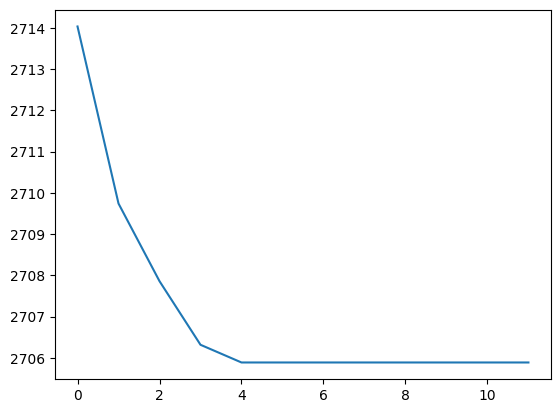

In [ ]:
plt.plot(predicted_prices)

In [ ]:
# Create a figure
fig = go.Figure()

# Add actual earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_val))),
    y=y_val.values,
    mode='lines',
    name='Actual Earnings',
    line=dict(color='blue')
))

# Add predicted earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))),
    y=y_pred,
    mode='lines',
    name='Predicted Earnings',
    line=dict(color='red', dash='dash')
))

# Customize layout
fig.update_layout(
    title='Actual vs. Predicted Earnings',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Earnings (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show the figure
fig.show()

Predicted future opening price: 2705.888427734375
Predicted future closing price: 2705.888427734375
Predicted future low price: 2705.888427734375
Predicted future high price: 2705.888427734375


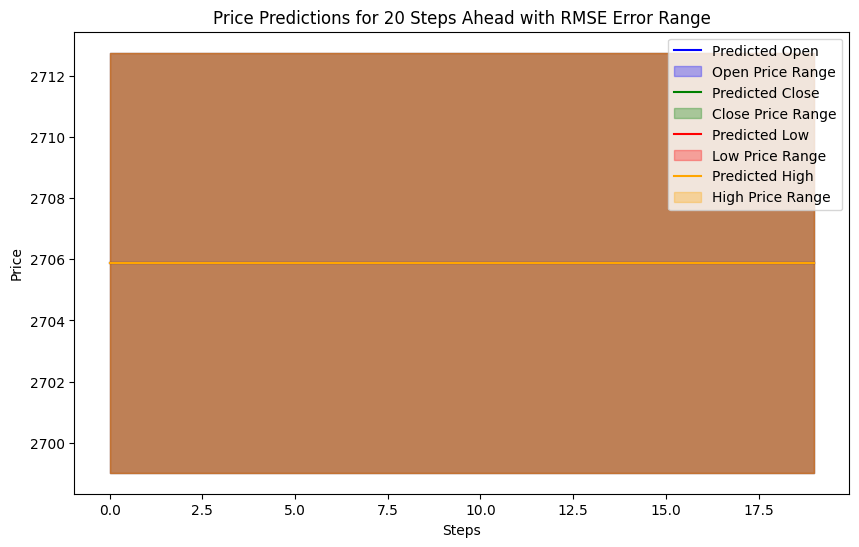

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming processed_df is your DataFrame and model is your trained RandomForestRegressor
# Let's assume you already have the RMSE value from model evaluation
rmse_value = (rf_rmse*1)/max(processed_df.Price.values)  # Example RMSE value (adjust this with your actual RMSE value)

# Define the lag columns (assuming you used 12 lags for the RandomForest model)
lag_columns = [f'lag_{i+1}' for i in range(12)]  # Adjust this based on your n_lags

# Get the last 12 data points from 'Open', 'Price', 'Low', and 'High'
open_prices = processed_df['Open'].tail(12).values
close_prices = processed_df['Price'].tail(12).values
low_prices = processed_df['Low'].tail(12).values
high_prices = processed_df['High'].tail(12).values

# Reshape the data to match the expected format (1 sample with 12 features)
X_input_open = open_prices.reshape(1, -1)  # Shape (1, 12)
X_input_close = close_prices.reshape(1, -1)  # Shape (1, 12)
X_input_low = low_prices.reshape(1, -1)  # Shape (1, 12)
X_input_high = high_prices.reshape(1, -1)  # Shape (1, 12)

# Convert them to DataFrame with the appropriate column names (matching model training data)
X_input_open_df = pd.DataFrame(X_input_open, columns=lag_columns)
X_input_close_df = pd.DataFrame(X_input_close, columns=lag_columns)
X_input_low_df = pd.DataFrame(X_input_low, columns=lag_columns)
X_input_high_df = pd.DataFrame(X_input_high, columns=lag_columns)

# Predict the next price using the Random Forest model (for open, close, low, high)
predicted_opening = model.predict(X_input_open_df)
predicted_closing = model.predict(X_input_close_df)
predicted_lowing = model.predict(X_input_low_df)
predicted_highing = model.predict(X_input_high_df)

# Output the predicted future prices
print("Predicted future opening price:", predicted_opening[0])
print("Predicted future closing price:", predicted_closing[0])
print("Predicted future low price:", predicted_lowing[0])
print("Predicted future high price:", predicted_highing[0])

# Number of steps to predict (you can change this depending on your needs)
steps = 20  # Set the number of steps (e.g., 5 steps ahead)

# Initialize lists to hold the predicted prices for multiple steps
predicted_open = [predicted_opening[0]]
predicted_close = [predicted_closing[0]]
predicted_low = [predicted_lowing[0]]
predicted_high = [predicted_highing[0]]

# Calculate predictions for multiple steps (not just one)
for step in range(1, steps):
    # Shift the prices by one step and predict for the next step
    X_input_open_df.iloc[0, :-1] = X_input_open_df.iloc[0, 1:].values  # Shift by 1 step
    X_input_close_df.iloc[0, :-1] = X_input_close_df.iloc[0, 1:].values  # Shift by 1 step
    X_input_low_df.iloc[0, :-1] = X_input_low_df.iloc[0, 1:].values  # Shift by 1 step
    X_input_high_df.iloc[0, :-1] = X_input_high_df.iloc[0, 1:].values  # Shift by 1 step

    # Predict the next price based on the shifted input
    predicted_opening = model.predict(X_input_open_df)
    predicted_closing = model.predict(X_input_close_df)
    predicted_lowing = model.predict(X_input_low_df)
    predicted_highing = model.predict(X_input_high_df)

    # Append predictions to the lists
    predicted_open.append(predicted_opening[0])
    predicted_close.append(predicted_closing[0])
    predicted_low.append(predicted_lowing[0])
    predicted_high.append(predicted_highing[0])

# Convert the lists to numpy arrays after collecting predictions
predicted_open = np.array(predicted_open)
predicted_close = np.array(predicted_close)
predicted_low = np.array(predicted_low)
predicted_high = np.array(predicted_high)

# Calculate the upper and lower range predictions using RMSE
upper_open = predicted_open * (1 + rmse_value)
lower_open = predicted_open * (1 - rmse_value)

upper_close = predicted_close * (1 + rmse_value)
lower_close = predicted_close * (1 - rmse_value)

upper_low = predicted_low * (1 + rmse_value)
lower_low = predicted_low * (1 - rmse_value)

upper_high = predicted_high * (1 + rmse_value)
lower_high = predicted_high * (1 - rmse_value)

# Plot the predicted prices and their ranges for each price type
plt.figure(figsize=(10, 6))

# Plot for Open Prices
plt.plot(predicted_open, label='Predicted Open', color='blue')
plt.fill_between(range(steps), lower_open, upper_open, color='blue', alpha=0.3, label='Open Price Range')

# Plot for Close Prices
plt.plot(predicted_close, label='Predicted Close', color='green')
plt.fill_between(range(steps), lower_close, upper_close, color='green', alpha=0.3, label='Close Price Range')

# Plot for Low Prices
plt.plot(predicted_low, label='Predicted Low', color='red')
plt.fill_between(range(steps), lower_low, upper_low, color='red', alpha=0.3, label='Low Price Range')

# Plot for High Prices
plt.plot(predicted_high, label='Predicted High', color='orange')
plt.fill_between(range(steps), lower_high, upper_high, color='orange', alpha=0.3, label='High Price Range')

# Add labels and legend
plt.title(f"Price Predictions for {steps} Steps Ahead with RMSE Error Range")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.legend()

# Show plot
plt.show()


In [ ]:
predicted_opening

array([2705.88842773])

##**Classification approach**

In [ ]:
#Data Preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
processed_df.columns

Index(['Time', 'Price', 'Open', 'High', 'Low', 'Change %'], dtype='object')

In [ ]:
#Importing the training set
dataset_train = processed_df.iloc[:3710].reset_index(drop=True)
training_set = dataset_train.iloc[:, 6:7].values

In [ ]:
#Data Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
training_set_scaled = scaler.fit_transform(training_set)

#Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(dataset_train)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping training set
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#Building the RNN with LSTM layers
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 20, batch_size = 32)

#Making Predictions on the Test Set
#We start by importing the test set

dataset_test = processed_df.iloc[3710:].reset_index(drop=True)
test_set = dataset_test.iloc[:, 6:7].values

total = pd.concat((dataset_train['Change %'], dataset_test['Change %']), axis = 0)
inputs = total[len(total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)


# Calculating metrics
r2 = r2_score(test_set, predicted_price)
mae = mean_absolute_error(test_set, predicted_price)
print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Visualising the results
plt.plot(test_set, color = 'red', label = 'XAUUSD real price')
plt.plot(predicted_price, color = 'blue', label = 'XAUUSD Predicted Price')
plt.title('XAUUSD Price Prediction')
plt.xlabel('Time step')
plt.ylabel('XAUUSD Close Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 327ms/step - loss: 1.0818
Epoch 2/20
 18/115 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - loss: 1.0455

KeyboardInterrupt: 

In [ ]:
# Importing required libraries
#import numpy as np
#import matplotlib.pyplot as plt
#import pandas as pd
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_absolute_error, r2_score
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM
#from keras.callbacks import EarlyStopping, ModelCheckpoint
#
## Setting the timestep as a variable
#TIMESTEP = 60
#
## Data preprocessing
#dataset_train = processed_df.iloc[:3500].reset_index(drop=True)
#training_set = dataset_train.iloc[:, 1:2].values
#
## Data normalization
#scaler = MinMaxScaler(feature_range=(0, 1))
#training_set_scaled = scaler.fit_transform(training_set)
#
## Creating a data structure with TIMESTEP timesteps and 1 output
#X_train = []
#y_train = []
#for i in range(TIMESTEP, len(dataset_train)):
#    X_train.append(training_set_scaled[i-TIMESTEP:i, 0])
#    y_train.append(training_set_scaled[i, 0])
#X_train, y_train = np.array(X_train), np.array(y_train)
#
## Splitting into training and validation sets
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#
## Reshaping training and validation sets
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Building the refined RNN with LSTM layers
#model = Sequential()
#model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(units = 128, return_sequences = True))
#model.add(Dropout(0.2))
#model.add(LSTM(units = 64))
#model.add(Dropout(0.2))
#model.add(Dense(units = 1))
#
## Compiling the model
#model.compile(optimizer='adam', loss='mean_squared_error')
#
## Callbacks for early stopping and saving the best model
#callbacks = [
#    EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1),
#    ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_daily/DL_DAILY_MODEL_L60_S1.joblib.keras', monitor='val_mae', save_best_only=True, verbose=1)
#]
#
## Training the model
#history = model.fit(
#    X_train, y_train,
#    validation_data=(X_val, y_val),
#    epochs=40,
#    batch_size=32,
#    callbacks=callbacks
#)
#
## Plotting training and validation loss/mae
#plt.figure(figsize=(12, 6))
#plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
##plt.plot(history.history['mae'], label='Training MAE')
##plt.plot(history.history['val_mae'], label='Validation MAE')
#plt.title('Training and Validation Metrics')
#plt.xlabel('Epochs')
#plt.ylabel('Loss / MAE')
#plt.legend()
#plt.show()

# Preparing test data
#dataset_test = processed_df.iloc[3500:].reset_index(drop=True)
#test_set = dataset_test.iloc[:, 1:2].values
#total = pd.concat((dataset_train['Price'], dataset_test['Price']), axis=0)
#inputs = total[len(total) - len(test_set) - TIMESTEP:].values.reshape(-1, 1)
#inputs = scaler.transform(inputs)
#
#X_test = []
#for i in range(TIMESTEP, inputs.shape[0]):
#    X_test.append(inputs[i-TIMESTEP:i, 0])
#X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#
## Making predictions on the test set
#predicted_price = model.predict(X_test)
#predicted_price = scaler.inverse_transform(predicted_price)
#
## Calculating metrics
#r2 = r2_score(test_set, predicted_price)
#mae = mean_absolute_error(test_set, predicted_price)
#print(f'R² Score: {r2:.4f}')
#print(f'Mean Absolute Error (MAE): {mae:.4f}')
#
## Visualizing the results
#plt.figure(figsize=(12, 6))
#plt.plot(test_set, color='red', label='Real XAUUSD Price')
#plt.plot(predicted_price, color='blue', label='Predicted XAUUSD Price')
#plt.title('XAUUSD Price Prediction')
#plt.xlabel('Time Step')
#plt.ylabel('Price')
#plt.legend()
#plt.show()

In [ ]:
def predict_multiple_steps(model, recent_data, scaler, timestep, num_steps):
    """
    Predict multiple future steps using the trained model.

    Parameters:
        model: Trained LSTM model
        recent_data: Latest data array (2D with shape (timestep, 1))
        scaler: Fitted MinMaxScaler instance
        timestep: Number of timesteps used for prediction
        num_steps: Number of steps to predict into the future

    Returns:
        future_predictions: Array of predicted prices
    """
    # Scale the recent data
    recent_scaled = scaler.transform(recent_data.reshape(-1, 1))
    future_predictions = []

    # Initialize the input with the last `timestep` data points
    current_input = recent_scaled[-timestep:].reshape(1, timestep, 1)  # Shape (1, timestep, 1)

    for _ in range(num_steps):
        # Predict the next step
        next_pred = model.predict(current_input)  # Shape (1, 1)

        # Append the predicted value to the list
        future_predictions.append(next_pred[0, 0])  # Extract the scalar value

        # Update the input window
        next_pred_reshaped = next_pred.reshape(1, 1, 1)  # Shape (1, 1, 1) to match input dimensions
        current_input = np.append(current_input[:, 1:, :], next_pred_reshaped, axis=1)

    # Inverse transform predictions to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions


In [ ]:
TIMESTEP = 60  # Number of timesteps used for training
future_steps = 30
latest_data = processed_df.iloc[-TIMESTEP:, 3:4].values  # Use the last TIMESTEP data points
future_prices = predict_multiple_steps(model, latest_data, scaler, TIMESTEP, future_steps)

print(f"Predicted prices for the next {future_steps} steps:")
print(future_prices.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_daily/DL_DAILY_Open_MODEL_L60_S1.keras')

In [ ]:
from keras.models import load_model
price_model = load_model('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_daily/DL_DAILY_Open_MODEL_L60_S1.keras')

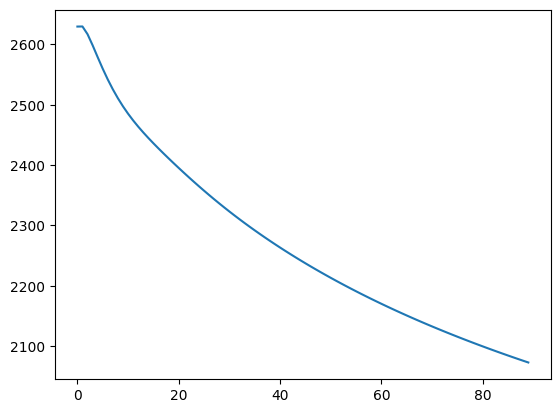

In [ ]:
plt.plot(future_prices.flatten())

##**DL Experiments**

X_train shape: (3650, 60, 5), y_train shape: (3650, 2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 302ms/step - loss: 0.0991 - mae: 0.2100 - val_loss: 0.0118 - val_mae: 0.0748
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 321ms/step - loss: 0.0144 - mae: 0.0891 - val_loss: 0.0132 - val_mae: 0.0794
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 273ms/step - loss: 0.0104 - mae: 0.0763 - val_loss: 0.0152 - val_mae: 0.0875
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - loss: 0.0110 - mae: 0.0795 - val_loss: 0.0098 - val_mae: 0.0853
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - loss: 0.0084 - mae: 0.0682 - val_loss: 0.0054 - val_mae: 0.0563
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - loss: 0.0077 - mae: 0.0670 - val_loss: 0.0111 - val_mae: 0.0933
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - loss: 0.0071 - mae: 0.0614 - val_loss: 0.0098 - val_mae: 0.0745
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 268ms/step - loss: 0.0068 - mae: 0.0612 - val_loss: 0.0099 - val_mae: 0.0736
Epoch 9/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/

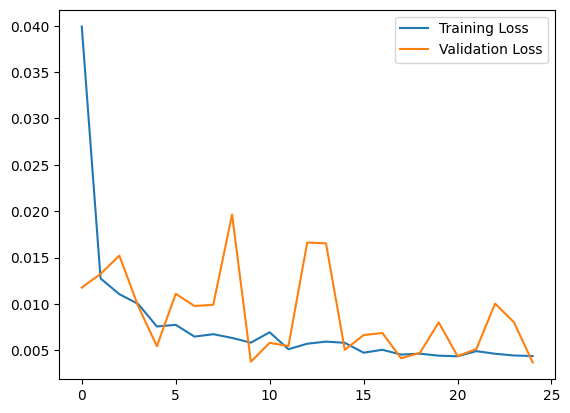

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping

# Hyperparameters
TIMESTEP = 60  # Number of timesteps
FUTURE_STEPS = 10  # Number of future steps to predict

# Load and process dataset
# Assuming `processed_df` is already loaded and cleaned
dataset_train = processed_df.iloc[:3710].reset_index(drop=True)

# Select features (all columns except 'Time') and targets ('High' and 'Low')
features = dataset_train[['Price', 'Open', 'High', 'Low', 'Change %']].values
targets = dataset_train[['High', 'Low']].values

# Normalize the data
scaler_features = StandardScaler()
scaler_targets = StandardScaler()
features_scaled = scaler_features.fit_transform(features)
targets_scaled = scaler_targets.fit_transform(targets)

# Create sequences for input (X_train) and output (y_train)
X_train = []
y_train = []
for i in range(TIMESTEP, len(dataset_train)):
    X_train.append(features_scaled[i - TIMESTEP:i])  # Last TIMESTEP rows for input
    y_train.append(targets_scaled[i])  # Current row's target for output
X_train, y_train = np.array(X_train), np.array(y_train)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# X_train shape: (samples, TIMESTEP, features), y_train shape: (samples, 2)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=2))  # Two outputs: High and Low

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with validation
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Save the model
#model.save('gold_price_lstm_model.h5')


In [ ]:
def predict_future_steps(model, latest_data, scaler_features, scaler_targets, timestep, future_steps):
    """
    Predict future steps based on the latest data.
    """
    predictions = []
    input_data = scaler_features.transform(latest_data[-timestep:])  # Normalize latest data
    input_data = input_data.reshape(1, timestep, -1)  # Reshape to (1, TIMESTEP, features)

    for _ in range(future_steps):
        pred = model.predict(input_data)
        predictions.append(pred[0])

        # Append the predicted values back into the input for the next step
        pred_features = np.zeros((1, 1, input_data.shape[-1]))
        pred_features[:, :, :2] = pred.reshape(1, 1, -1)  # Set predicted 'High' and 'Low'
        pred_features[:, :, 2:] = input_data[:, -1, 2:]  # Carry forward other feature values

        input_data = np.concatenate([input_data[:, 1:], pred_features], axis=1)

    predictions = np.array(predictions)
    predictions = scaler_targets.inverse_transform(predictions)  # Reverse scaling for predictions
    return predictions

# Generate predictions
latest_data = processed_df.iloc[-TIMESTEP:, 1:].values  # Use last TIMESTEP rows
future_predictions = predict_future_steps(model, latest_data, scaler_features, scaler_targets, TIMESTEP, FUTURE_STEPS)

print(f"Future predictions for High and Low prices:\n{future_predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Future predictions for High and Low prices:
[[2274.442  2199.2727]
 [2274.883  2199.5525]
 [2274.3042 2199.0713]
 [2273.39   2198.3242]
 [2272.4075 2197.528 ]
 [2271.4797 2196.7888]
 [2270.644  2196.138 ]
 [2269.9036 2195.577 ]
 [2269.2495 2195.0962]
 [2268.6719 2194.6836]]


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Validation predictions
val_predictions = model.predict(X_train[:len(y_train)])
val_predictions = scaler_targets.inverse_transform(val_predictions)
y_true = scaler_targets.inverse_transform(y_train)

# Metrics
mae = mean_absolute_error(y_true, val_predictions)
r2 = r2_score(y_true, val_predictions)

print(f"Validation MAE: {mae}")
print(f"Validation R²: {r2}")


115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step
Validation MAE: 10.020788225064202
Validation R²: 0.9975634088680183


115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step


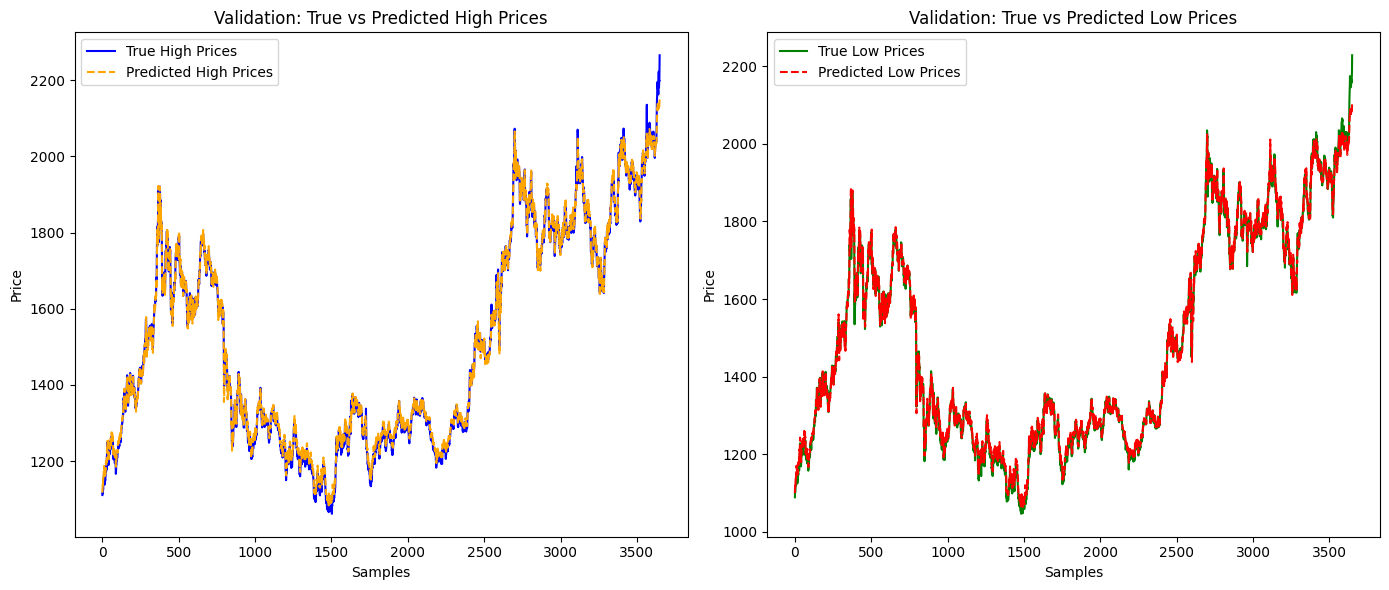

In [ ]:
import matplotlib.pyplot as plt

# Predict on the entire training dataset (to simulate validation results)
val_predictions = model.predict(X_train)
val_predictions = scaler_targets.inverse_transform(val_predictions)  # Reverse scaling
y_true = scaler_targets.inverse_transform(y_train)

# Separate High and Low prices for easier comparison
y_true_high, y_true_low = y_true[:, 0], y_true[:, 1]
predicted_high, predicted_low = val_predictions[:, 0], val_predictions[:, 1]

# Plot High prices
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # Subplot for High prices
plt.plot(y_true_high, label='True High Prices', color='blue')
plt.plot(predicted_high, label='Predicted High Prices', color='orange', linestyle='--')
plt.title('Validation: True vs Predicted High Prices')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()

# Plot Low prices
plt.subplot(1, 2, 2)  # Subplot for Low prices
plt.plot(y_true_low, label='True Low Prices', color='green')
plt.plot(predicted_low, label='Predicted Low Prices', color='red', linestyle='--')
plt.title('Validation: True vs Predicted Low Prices')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


##**Differential approach**

In [ ]:
processed_df.iloc[-1].to_dict()

{'Time': Timestamp('2024-11-22 00:00:00'),
 'Price': 2712.55,
 'Open': 2669.84,
 'High': 2712.91,
 'Low': 2667.38,
 'Change %': 0.0161}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention
from sklearn.metrics import mean_absolute_error


df = processed_df

# 1. Calculate differential features (daily returns)
df['Price_return'] = df['Price'].diff()
df['Open_return'] = df['Open'].diff()
df['High_return'] = df['High'].diff()
df['Low_return'] = df['Low'].diff()

# Adding Moving Averages (SMA and EMA)
df['SMA_10'] = df['Price'].rolling(window=10).mean()  # 10-day Simple Moving Average
df['SMA_30'] = df['Price'].rolling(window=30).mean()  # 30-day Simple Moving Average
df['EMA_10'] = df['Price'].ewm(span=10, adjust=False).mean()  # 10-day Exponential Moving Average
df['EMA_30'] = df['Price'].ewm(span=30, adjust=False).mean()  # 30-day Exponential Moving Average

# Adding Volatility (Rolling Standard Deviation)
df['Volatility_10'] = df['Price'].rolling(window=10).std()  # 10-day rolling volatility
df['Volatility_30'] = df['Price'].rolling(window=30).std()  # 30-day rolling volatility

# Drop NaNs introduced by diff()
df = df.dropna().reset_index(drop=True)

# 2. Prepare data for neural network training
def prepare_sequences(df, input_features, target_features, n_steps):
    X, y = [], []
    for i in range(len(df) - n_steps):
        X.append(df[input_features].iloc[i:i+n_steps].values)
        y.append(df[target_features].iloc[i+n_steps].values)
    return np.array(X), np.array(y)

# Define features
input_features = ['Price_return', 'Open_return', 'SMA_10', 'SMA_30', 'Volatility_10', 'Volatility_30','High_return','Low_return']
target_features = ['High_return', 'Low_return']
n_steps = 50  # Length of historical window

X, y = prepare_sequences(df, input_features, target_features, n_steps)

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(X.reshape(-1, len(input_features))).reshape(X.shape)
y = scaler_y.fit_transform(y)

# Train-test split (80-20)
split_idx = int(len(X) * 0.9)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Permute, Multiply, Lambda, Softmax
import tensorflow.keras.backend as K

def build_advanced_lstm_model(input_shape, output_size):
    model = Sequential()

    # First LSTM layer, return sequences for next LSTM layer
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    # Second LSTM layer
    model.add(LSTM(32))
    model.add(Dropout(0.2))

    # Dense layer with two outputs (High_return and Low_return)
    model.add(Dense(output_size))  # Output layer for 2 predictions

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model
# Build and summarize the model
input_shape = (n_steps, len(input_features))  # Example: (30, 2)
output_size = 2  # Predicting High_return and Low_return
model = build_advanced_lstm_model(input_shape, output_size)
model.summary()





# Train the model
from tensorflow.keras.callbacks import Callback

class ValidationMetrics(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data  # Unpack validation data
        y_pred_val = self.model.predict(X_val)
        y_pred_val = scaler_y.inverse_transform(y_pred_val)
        y_true_val = scaler_y.inverse_transform(y_val)

        # Calculate metrics
        val_r2 = r2_score(y_true_val, y_pred_val)
        val_mae = mean_absolute_error(y_true_val, y_pred_val)

        # Log metrics
        print(f"Epoch {epoch+1} - Validation R²: {val_r2:.4f}, Validation MAE: {val_mae:.4f}")
# Initialize the ValidationMetrics callback
val_metrics = ValidationMetrics(validation_data=(X_test, y_test))

# Train the model with the callback
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[val_metrics],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 50, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,170 (121.76 KB)

 Trainable params: 31,170 (121.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1 - Validation R²: -0.0602, Validation MAE: 12.6577
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0272 - val_loss: 0.0077
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 2 - Validation R²: -0.0846, Validation MAE: 12.9052
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 3 - Validation R²: -0.1017, Validation MAE: 13.0306
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 4 - Validation R²: -0.3648, Validation MAE: 15.1765
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0066 - val_loss: 0.0098
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 5 - Validation R²: -0.0213, Validation MAE: 12.3749
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 6 - Validation R²: -0.

In [ ]:
# 4. Evaluate and visualize results
y_pred_test = model.predict(X_test)
import plotly.graph_objects as go
import plotly.io as pio

# Set default renderer for Plotly
pio.renderers.default = 'colab'

# Inverse transform predictions and true values
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test)
y_test_inverse = scaler_y.inverse_transform(y_test)

# High_return Plot
fig_high = go.Figure()

# Add actual High_return trace
fig_high.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test_inverse[:, 0],
    mode='lines',
    name='Actual High_return',
    line=dict(color='blue')
))

# Add predicted High_return trace
fig_high.add_trace(go.Scatter(
    x=list(range(len(y_pred_test))),
    y=y_pred_test_inverse[:, 0],
    mode='lines',
    name='Predicted High_return',
    line=dict(color='red', dash='dash')
))

# Customize layout for High_return
fig_high.update_layout(
    title='Actual vs. Predicted High_return',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='High Return (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show High_return plot
fig_high.show()

# Low_return Plot
fig_low = go.Figure()

# Add actual Low_return trace
fig_low.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test_inverse[:, 1],
    mode='lines',
    name='Actual Low_return',
    line=dict(color='blue')
))

# Add predicted Low_return trace
fig_low.add_trace(go.Scatter(
    x=list(range(len(y_pred_test))),
    y=y_pred_test_inverse[:, 1],
    mode='lines',
    name='Predicted Low_return',
    line=dict(color='red', dash='dash')
))

# Customize layout for Low_return
fig_low.update_layout(
    title='Actual vs. Predicted Low_return',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Low Return (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show Low_return plot
fig_low.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# 5. Predict the future based on the most recent data
from sklearn.metrics import r2_score, mean_absolute_error

# 1. Modified predict_future function for multi-day forecasting
def predict_future(df, n_steps, input_features, forecast_days):
    predictions = []
    last_window = df[input_features].iloc[-n_steps:].values
    last_window_scaled = scaler_X.transform(last_window)

    # Iteratively predict future days
    for _ in range(forecast_days):
        last_window_scaled = last_window_scaled.reshape(1, n_steps, len(input_features))
        future_return = model.predict(last_window_scaled)
        future_return_inverse = scaler_y.inverse_transform(future_return)
        predictions.append(future_return_inverse.flatten())  # Collect predictions

        # Update the window with the predicted values
        new_row = scaler_X.inverse_transform(last_window_scaled[0])[-1]  # Take the latest feature values
        new_row[:2] = future_return  # Replace target feature values with predictions
        # Ensure last_window_scaled[0][1:] is 2D by reshaping
        last_window_scaled_reshaped = last_window_scaled[0][1:].reshape(-1, last_window_scaled.shape[2])

        # Ensure new_row is 2D before transforming
        new_row_scaled = scaler_X.transform(new_row.reshape(1, -1))

        # Now stack the arrays vertically (axis=0)
        last_window_scaled = np.vstack([last_window_scaled_reshaped, new_row_scaled])


    return np.array(predictions)

# Forecast the next 5 days
forecast_days = 20
future_predictions = predict_future(df, n_steps, input_features, forecast_days)
print(f"Future Predictions (High_return, Low_return) for {forecast_days} days:\n{future_predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Future Predictions (High_return, Low_return) for 20 days:
[[ 11.832586   21.068148 ]
 [-16.489594   -5.4155083]
 [-37.13515   -16.01673  ]
 [-48.172398  -20.955862 ]
 [-50.60753   -21.464298 ]
 [-48.280186  -20.714748 ]
 [-44.03489   -19.73

In [ ]:
btc_df.iloc[-1].to_dict()
#'[-8.2065680e+02 -6.4996991e+02]'

{'Time': Timestamp('2024-11-24 00:00:00'),
 'Price': 96011.5,
 'Open': 97696.4,
 'High': 98552.6,
 'Low': 95791.4,
 'Change %': -0.0173,
 'Price_return': -1687.5,
 'Open_return': -1230.800000000003,
 'High_return': -374.59999999999127,
 'Low_return': -1389.5,
 'SMA_10': 93945.58,
 'SMA_30': 81468.96666666666,
 'EMA_10': 93679.35059104403,
 'EMA_30': 84206.05082681419,
 'Volatility_10': 3571.3160119672725,
 'Volatility_30': 11114.845697792996,
 'daily_return': -1684.8999999999942}

In [ ]:
processed_df.iloc[-1].to_dict()

{'Time': Timestamp('2024-11-22 00:00:00'),
 'Price': 2712.55,
 'Open': 2669.84,
 'High': 2712.91,
 'Low': 2667.38,
 'Change %': 0.0161,
 'Price_return': 42.86000000000013,
 'Open_return': 19.65000000000009,
 'High_return': 39.04999999999973,
 'Low_return': 19.43000000000029}

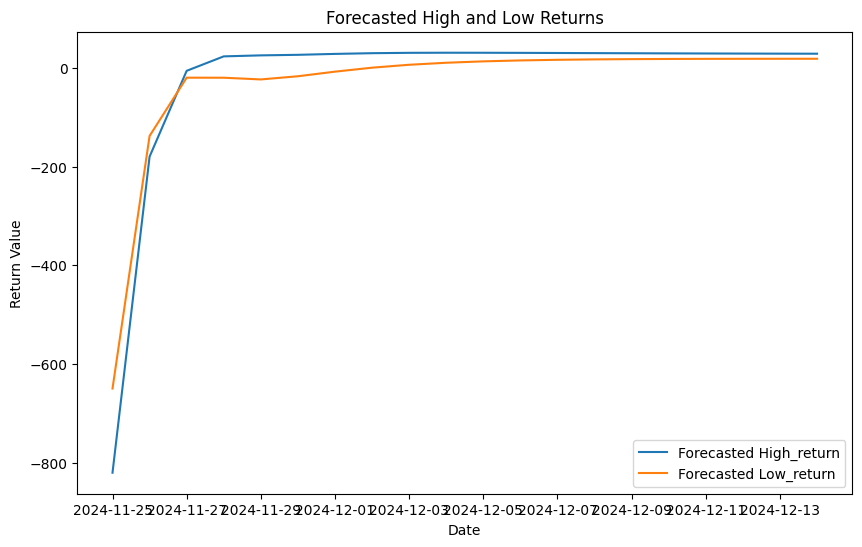

In [ ]:
future_dates = [df['Time'].iloc[-1] + pd.Timedelta(days=i+1) for i in range(forecast_days)]

# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions[:, 0], label="Forecasted High_return")
plt.plot(future_dates, future_predictions[:, 1], label="Forecasted Low_return")
plt.title("Forecasted High and Low Returns")
plt.xlabel("Date")
plt.ylabel("Return Value")
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

def plot_predictions(true_values, predictions, title="Multi-Step Forecast"):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y=true_values.flatten(),
        mode="lines",
        name="True Values",
        line=dict(color="blue")
    ))
    fig.add_trace(go.Scatter(
        y=predictions.flatten(),
        mode="lines",
        name="Predictions",
        line=dict(color="red", dash="dash")
    ))
    fig.update_layout(
        title=title,
        xaxis=dict(title="Time Steps"),
        yaxis=dict(title="Price"),
        template="plotly_white"
    )
    fig.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_sign_accuracy(y_true, y_pred):
    # Convert values to signs (-1 for negative, 1 for positive, 0 for zero)
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)

    # Calculate accuracy in sign prediction
    sign_accuracy = accuracy_score(y_true_sign, y_pred_sign)

    # Confusion matrix for directional predictions
    cm = confusion_matrix(y_true_sign, y_pred_sign, labels=[-1, 0, 1])

    # Display results
    print("Sign Accuracy: {:.2%}".format(sign_accuracy))
    print("Confusion Matrix (rows: actual, cols: predicted):\n", cm)

    return sign_accuracy, cm

# Inverse transform predictions and actual values for evaluation
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test)
y_test_inverse = scaler_y.inverse_transform(y_test)

# Evaluate sign accuracy for each target dimension
print("High_return Sign Prediction:")
sign_accuracy_high, cm_high = evaluate_sign_accuracy(y_test_inverse[:, 0], y_pred_test_inverse[:, 0])

print("\nLow_return Sign Prediction:")
sign_accuracy_low, cm_low = evaluate_sign_accuracy(y_test_inverse[:, 1], y_pred_test_inverse[:, 1])


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/HFFX_Project/xau_usd_daily/DL_DAILY_HLR_MODEL_L12_S1.keras')

In [ ]:
#[[TN   FP   FN]
# [0    0    0 ]  # Rows for zero predictions (usually irrelevant here)
# [FN   FP   TP]]

In [ ]:
def predict_future_multiple_days(model, X_input, n_days=5):
    """
    Predict multiple days ahead using the trained model.

    Parameters:
        model: Trained model.
        X_input: Input features (last window of data).
        n_days: Number of days to forecast.

    Returns:
        List of predictions for n days ahead.
    """
    # Store predictions for multiple days
    future_predictions = []

    # Use the current window to predict future values
    current_input = X_input

    for _ in range(n_days):
        # Predict for the next day
        y_pred_next = model.predict(current_input)

        # Add prediction to the list
        future_predictions.append(y_pred_next)

        # Update the input for the next day
        # Add the predicted values as the new input for the model
        current_input = np.append(current_input[:, 1:, :], y_pred_next.reshape(1, 1, -1), axis=1)

    # Convert the predictions to a 2D array (n_days x features)
    future_predictions = np.array(future_predictions).reshape(n_days, -1)

    # Inverse transform predictions if needed
    future_predictions = scaler_y.inverse_transform(future_predictions)

    return future_predictions


In [ ]:
# Set the number of days to forecast
n_days = 5

# Use the last available window of data (X_input) from the test set or the latest data
X_input_last_window = X_test[-1].reshape(1, n_days, X_train.shape[2])

# Predict multiple days
future_predictions = predict_future_multiple_days(model, X_input_last_window, n_days)

# Print the future predictions for high and low return prices
print("Future High Return Predictions (in USD):")
print(future_predictions[:, 0])

print("\nFuture Low Return Predictions (in USD):")
print(future_predictions[:, 1])


ValueError: cannot reshape array of size 200 into shape (1,5,2)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

# Assuming btc_df is already preprocessed (e.g., btc_df.dropna())
df = processed_df
# 1. Calculate differential features (daily returns)
df['Price_return'] = df['Price'].diff()
df['Open_return'] = df['Open'].diff()
df['High_return'] = df['High'].diff()
df['Low_return'] = df['Low'].diff()

# 2. Adding Moving Averages (SMA and EMA)
df['SMA_10'] = df['Price'].rolling(window=10).mean()  # 10-day Simple Moving Average
df['SMA_30'] = df['Price'].rolling(window=30).mean()  # 30-day Simple Moving Average
df['EMA_10'] = df['Price'].ewm(span=10, adjust=False).mean()  # 10-day Exponential Moving Average
df['EMA_30'] = df['Price'].ewm(span=30, adjust=False).mean()  # 30-day Exponential Moving Average

# 3. Adding Volatility (Rolling Standard Deviation)
df['Volatility_10'] = df['Price'].rolling(window=10).std()  # 10-day rolling volatility
df['Volatility_30'] = df['Price'].rolling(window=30).std()  # 30-day rolling volatility

# 4. Adding daily_return (Price - Open)
df['daily_return'] = df['Price'] - df['Open']

# Drop NaNs introduced by diff()
df = df.dropna().reset_index(drop=True)

def prepare_sequences(df, input_features, target_features, n_steps, m_steps):
    X, y = [], []
    for i in range(len(df) - n_steps - m_steps + 1):
        # X: n points up to `i + n_steps`
        X.append(df[input_features].iloc[i:i + n_steps].values)
        # y: m points starting immediately after `X`
        y.append(df[target_features].iloc[i + n_steps:i + n_steps + m_steps].values)
    return np.array(X), np.array(y)


# Configuration
input_features = ['Price_return', 'Open_return', 'SMA_10', 'SMA_30', 'Volatility_10', 'Volatility_30','High_return','Low_return','Open','Price','Low','High']
target_features = ['High_return','Low_return']
n_steps = 100
m_steps = 1

# Prepare sequences
X, y = prepare_sequences(df, input_features, target_features, n_steps, m_steps)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(X.reshape(-1, len(input_features))).reshape(X.shape)
y = scaler_y.fit_transform(y.reshape(-1, len(target_features))).reshape(y.shape)

# Train-test split
split_idx = int(len(X) * 0.9)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build LSTM model
def build_advanced_lstm_model(input_shape, output_size, m_steps):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32, return_sequences=False),
        Dense(m_steps * output_size),
        Reshape((m_steps, output_size))  # Reshape to (m_steps, output_size)
    ])
    return model

input_shape = (n_steps, len(input_features))
output_size = len(target_features)
model = build_advanced_lstm_model(input_shape, output_size, m_steps)

# Compile model
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# ValidationMetrics Callback
class ValidationMetrics(Callback):
    def __init__(self, validation_data, scaler_y):
        super().__init__()
        self.validation_data = validation_data
        self.scaler_y = scaler_y

    def on_epoch_end(self, epoch, logs=None):
        try:
            X_val, y_val = self.validation_data
            y_pred_val = self.model.predict(X_val)

            # Reshape predictions and true values for scaling back
            y_pred_val = y_pred_val.reshape(-1, y_pred_val.shape[-1])
            y_true_val = y_val.reshape(-1, y_val.shape[-1])

            y_pred_val = self.scaler_y.inverse_transform(y_pred_val)
            y_true_val = self.scaler_y.inverse_transform(y_true_val)

            # Compute metrics
            val_r2 = r2_score(y_true_val, y_pred_val)
            val_mae = mean_absolute_error(y_true_val, y_pred_val)
            print(f"Epoch {epoch+1} - Validation R²: {val_r2:.4f}, Validation MAE: {val_mae:.4f}")
        except Exception as e:
            print(f"Epoch {epoch+1} - Error in validation metrics: {e}")

# Callbacks
early_stopping = EarlyStopping(monitor='val_mae', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6)
metrics_callback = ValidationMetrics(validation_data=(X_test, y_test), scaler_y=scaler_y)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, metrics_callback],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Epoch 1 - Validation R²: -0.0709, Validation MAE: 13.7839
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.1032 - mae: 0.1032 - val_loss: 0.0695 - val_mae: 0.0695 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 2 - Validation R²: -0.0868, Validation MAE: 14.1090
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0469 - mae: 0.0469 - val_loss: 0.0708 - val_mae: 0.0708 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 3 - Validation R²: -0.1495, Validation MAE: 14.7800
182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.0463 - mae: 0.0463 - val_loss: 0.0741 - val_mae: 0.0741 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 4 - Validation R²: -0.0368, Validation MAE: 13.7275
182/182 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.0464 - mae: 0.0464 - val_loss: 0.0689 - val_mae: 0.0689 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
def predict_future(df, n_steps, m_steps, input_features, target_features, forecast_days, scaler_X, scaler_y, model):
    """
    Predicts future values using the trained model, accommodating n_steps inputs and m_steps outputs.

    Args:
        df (pd.DataFrame): Dataframe containing the input features.
        n_steps (int): Number of timesteps for input sequences.
        m_steps (int): Number of timesteps for prediction output.
        input_features (list): List of input feature columns.
        target_features (list): List of target feature columns.
        forecast_days (int): Total number of timesteps to predict.
        scaler_X: Scaler used to scale input features.
        scaler_y: Scaler used to scale target features.
        model: Trained Keras model.

    Returns:
        np.array: Predicted future values (scaled back to original range).
    """
    # Extract the last n_steps of input data
    future_data = df[input_features].iloc[-n_steps:].values
    future_data = scaler_X.transform(future_data)  # Scale input features
    future_predictions = []

    for _ in range(forecast_days // m_steps):
        # Reshape the input data for prediction
        future_data_reshaped = future_data.reshape(1, n_steps, len(input_features))

        # Predict the next m_steps
        prediction = model.predict(future_data_reshaped, verbose=0)  # Shape: (1, m_steps, len(target_features))

        # Scale back the predictions to the original range
        prediction = scaler_y.inverse_transform(prediction[0])  # Shape: (m_steps, len(target_features))
        future_predictions.append(prediction)

        # Update the future_data for the next prediction
        # Use only the required number of target features and match the input feature dimensions
        new_data = np.zeros((m_steps, len(input_features)))  # Initialize with the correct input feature size
        for i, feature in enumerate(target_features):
            if feature in input_features:
                new_data[:, input_features.index(feature)] = prediction[:, target_features.index(feature)]

        future_data = np.concatenate((future_data[m_steps:], new_data), axis=0)

    return np.concatenate(future_predictions, axis=0)




# Define your features
input_features = ['Price_return', 'Open_return', 'SMA_10', 'SMA_30', 'Volatility_10', 'Volatility_30','High_return','Low_return','Open','Price','Low','High']
target_features = ['High_return','Low_return']
forecast_days = 20

# Assuming scalers and model are already defined
future_predictions = predict_future(
    df=processed_df,
    n_steps=n_steps,
    m_steps=m_steps,
    input_features=input_features,
    target_features=target_features,
    forecast_days=forecast_days,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    model=model
)

print("Future predictions shape:", future_predictions.shape)


# Assuming your model is predicting 10 features, but scaler_y was fitted on 2
y_pred_test = model.predict(X_test)

# Reshape the predictions and test data to 2D
y_pred_test_reshaped = y_pred_test.reshape(-1, y_pred_test.shape[-1])
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])

# Apply inverse transformation
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test_reshaped)
y_test_inverse = scaler_y.inverse_transform(y_test_reshaped)

# Check reshaped shapes
print(f"Shape of y_pred_test_inverse: {y_pred_test_inverse.shape}")
print(f"Shape of y_test_inverse: {y_test_inverse.shape}")

# Evaluate the model
r2 = r2_score(y_test_inverse, y_pred_test_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_test_inverse)

print(f"Test R²: {r2:.4f}, Test MAE: {mae:.4f}")
print(future_predictions)



Future predictions shape: (20, 2)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Shape of y_pred_test_inverse: (324, 2)
Shape of y_test_inverse: (324, 2)
Test R²: 0.3818, Test MAE: 10.1969
[[ -35.00685    -3.719514]
 [  31.274086  -41.204082]
 [ -78.814896  163.2223  ]
 [-179.87769   -55.131824]
 [ -28.880207  -79.93495 ]
 [ -52.959755 -122.41205 ]
 [ -86.45586  -135.17612 ]
 [-116.35597  -162.43956 ]
 [-134.92986  -185.85365 ]
 [-138.05225  -194.98567 ]
 [-137.62735  -197.56721 ]
 [-137.76772  -198.98125 ]
 [-138.49872  -199.483   ]
 [-139.39925  -199.20255 ]
 [-140.23985  -198.4467  ]
 [-140.92694  -197.46654 ]
 [-141.40587  -196.3966  ]
 [-141.64896  -195.31085 ]
 [-141.66263  -194.26115 ]
 [-141.48001  -193.28217 ]]


In [ ]:
processed_df.iloc[-2].to_dict()

{'Time': Timestamp('2024-11-24 00:00:00'),
 'Price': 2719.85,
 'Open': 2711.84,
 'High': 2721.34,
 'Low': 2710.8,
 'Change %': 0.0027}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_with_separate_confusion_matrices(
    model, X_test, y_test, scaler_y, target_labels, threshold=0.5
):
    """
    Evaluate the model and plot confusion matrices for each target separately.

    Args:
        model: Trained model to evaluate.
        X_test: Test input data.
        y_test: Test target data (scaled).
        scaler_y: Scaler used for the target data (for inverse transformation).
        target_labels: List of labels (e.g., ['Downtrend', 'Uptrend']).
        threshold: Decision threshold for binary classification.
    """
    # Predict using the model
    y_pred = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))
    y_test = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))

    # Binarize predictions and test data based on returns > 0
    y_pred_binary = (y_pred > 0).astype(int)
    y_test_binary = (y_test > 0).astype(int)

    # Evaluate for each target feature (column)
    for i, feature in enumerate(['High_return', 'Low_return']):
        print(f"Confusion Matrix for {feature}:")

        # Confusion matrix and metrics
        cm = confusion_matrix(y_test_binary[:, i], y_pred_binary[:, i])
        report = classification_report(
            y_test_binary[:, i], y_pred_binary[:, i], target_names=target_labels
        )

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
        plt.title(f'Confusion Matrix for {feature}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Print metrics
        print(report)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Confusion Matrix for High_return:


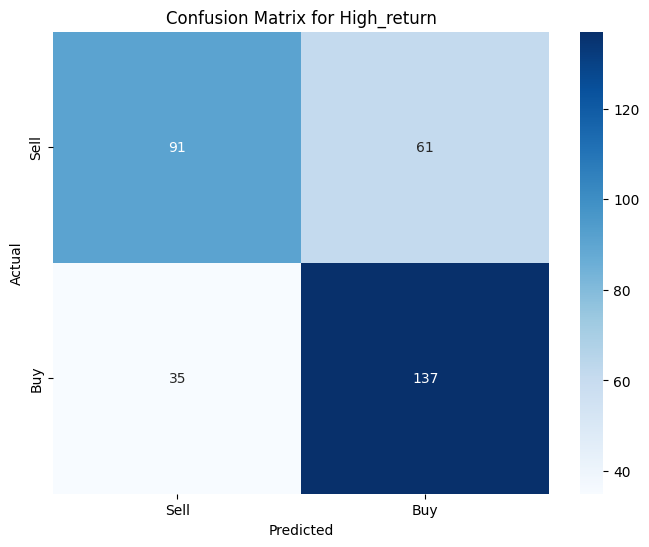

              precision    recall  f1-score   support

        Sell       0.72      0.60      0.65       152
         Buy       0.69      0.80      0.74       172

    accuracy                           0.70       324
   macro avg       0.71      0.70      0.70       324
weighted avg       0.71      0.70      0.70       324

Confusion Matrix for Low_return:


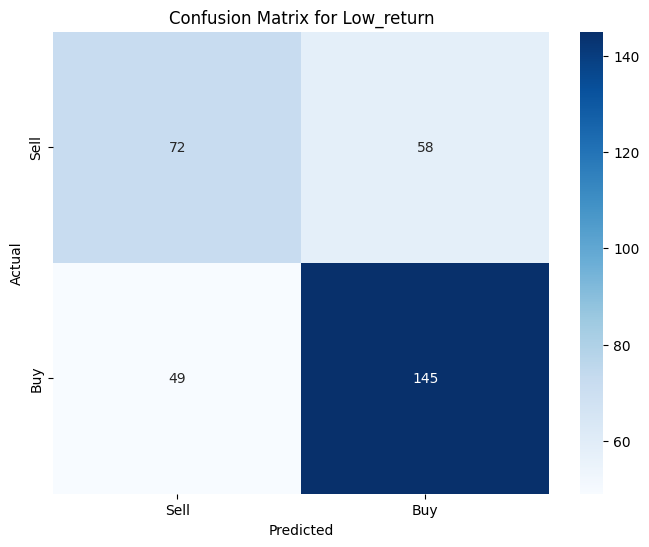

              precision    recall  f1-score   support

        Sell       0.60      0.55      0.57       130
         Buy       0.71      0.75      0.73       194

    accuracy                           0.67       324
   macro avg       0.65      0.65      0.65       324
weighted avg       0.67      0.67      0.67       324



In [ ]:
evaluate_model_with_separate_confusion_matrices(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler_y=scaler_y,
    target_labels=['Sell', 'Buy']
)


Accuracy: 0.68, Recall: 0.68, F1 Score: 0.67

Classification Report:
               precision    recall  f1-score   support

        Sell       0.81      0.48      0.60       244
         Buy       0.62      0.89      0.73       236

    accuracy                           0.68       480
   macro avg       0.72      0.68      0.67       480
weighted avg       0.72      0.68      0.67       480



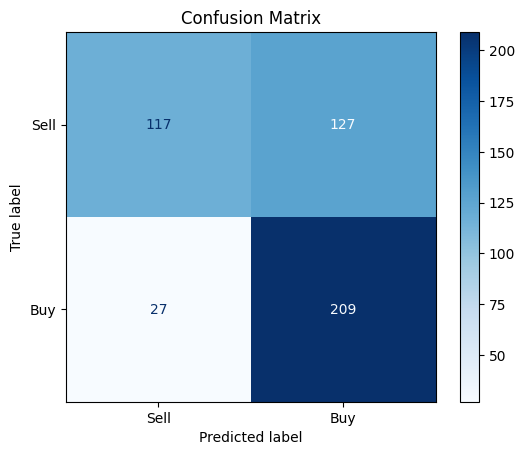

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay

def evaluate_model_with_confusion_matrix(model, X_test, y_test, scaler_y, threshold=0.5, target_labels=None):
    """
    Evaluates the model on the test set and visualizes the confusion matrix.

    Args:
        model: Trained Keras model.
        X_test (np.array): Test input features.
        y_test (np.array): Test ground truth labels (scaled).
        scaler_y: Scaler used for target features.
        threshold (float): Threshold to convert probabilities to binary predictions (for binary classification).
        target_labels (list): List of class labels for multi-class classification.

    Returns:
        None
    """
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)

    # Scale back the predictions
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))
    y_true = scaler_y.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))

    # Threshold or argmax predictions (adjust for multi-class/binary classification)
    if y_pred.shape[-1] > 1:  # Multi-class classification
        y_pred_class = np.argmax(y_pred, axis=1)
        y_true_class = np.argmax(y_true, axis=1)
    else:  # Binary classification
        y_pred_class = (y_pred.flatten() >= threshold).astype(int)
        y_true_class = (y_true.flatten() >= threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_true_class, y_pred_class)
    recall = recall_score(y_true_class, y_pred_class, average='weighted')
    f1 = f1_score(y_true_class, y_pred_class, average='weighted')
    print(f"Accuracy: {acc:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print("\nClassification Report:\n", classification_report(y_true_class, y_pred_class, target_names=target_labels))

    # Compute confusion matrix
    cm = confusion_matrix(y_true_class, y_pred_class)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Example Usage
# Assuming `X_test` and `y_test` are your test dataset arrays
# and `scaler_y` is used for inverse transforming target predictions
target_labels = ['Sell', 'Buy']  # Adjust labels based on your data
evaluate_model_with_confusion_matrix(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler_y=scaler_y,
    threshold=0.5,  # For binary classification
    target_labels=target_labels
)



In [ ]:
#[[TN   FP   FN]
# [0    0    0 ]  # Rows for zero predictions (usually irrelevant here)
# [FN   FP   TP]]

In [ ]:
processed_df.iloc[-1].to_dict()

{'Time': Timestamp('2024-11-25 00:00:00'),
 'Price': 2671.36,
 'Open': 2719.48,
 'High': 2720.18,
 'Low': 2659.31,
 'Change %': -0.0178}

In [ ]:
y_pred_test = model.predict(X_test)
import plotly.graph_objects as go
import plotly.io as pio
# High_return Plot
fig_high = go.Figure()

# Add actual High_return trace
fig_high.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test_inverse[:, 0],
    mode='lines',
    name='Actual High_return',
    line=dict(color='blue')
))

# Add predicted High_return trace
fig_high.add_trace(go.Scatter(
    x=list(range(len(y_pred_test))),
    y=y_pred_test_inverse[:, 0],
    mode='lines',
    name='Predicted High_return',
    line=dict(color='red', dash='dash')
))

# Customize layout for High_return
fig_high.update_layout(
    title='Actual vs. Predicted High_return',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='High Return (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show High_return plot
fig_high.show()

# Low_return Plot
fig_low = go.Figure()

# Add actual Low_return trace
fig_low.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test_inverse[:, 1],
    mode='lines',
    name='Actual Low_return',
    line=dict(color='blue')
))

# Add predicted Low_return trace
fig_low.add_trace(go.Scatter(
    x=list(range(len(y_pred_test))),
    y=y_pred_test_inverse[:, 1],
    mode='lines',
    name='Predicted Low_return',
    line=dict(color='red', dash='dash')
))

# Customize layout for Low_return
fig_low.update_layout(
    title='Actual vs. Predicted Low_return',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Low Return (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show Low_return plot
fig_low.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [ ]:
fig_daily = go.Figure()

# Add actual Low_return trace
fig_daily.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test_inverse[:, 0],
    mode='lines',
    name='Actual Daily_return',
    line=dict(color='blue')
))

# Add predicted Low_return trace
fig_daily.add_trace(go.Scatter(
    x=list(range(len(y_pred_test))),
    y=y_pred_test_inverse[:, 0],
    mode='lines',
    name='Predicted Daily_return',
    line=dict(color='red', dash='dash')
))

# Customize layout for Low_return
fig_daily.update_layout(
    title='Actual vs. Predicted Daily_return',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Low Return (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show Low_return plot
fig_daily.show()